In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import wilcoxon, kruskal, alexandergovern, mannwhitneyu
from statsmodels.stats.contingency_tables import mcnemar

# Utils

In [2]:
def map_time(df):
    empty_df = pd.DataFrame()
    new_df = pd.concat([empty_df, df[[col for col in df.columns if 'Tempo' in col and col != '20. Paura (Temporali)']]], axis=1)
    new_df['Tempo alla TV'] = df[['Tempo alla TV']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+ di 2 ore' else 0).astype('int')
    new_df['Tempo sui Videogames'] = df[['Tempo sui Videogames']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+di 2 ore' else 0).astype('int')
    new_df['Tempo sui Videogames Elettronici'] = df[['Tempo sui Videogames Elettronici']].applymap(lambda x: 1 if x == '- di 1ora al giorno' else 2 if x == 'Da1 a 2 ore' else 3 if x == '+di 2 ore' else 0).astype('int')
    new_df['Tempo sui social-network'] = df[['Tempo sui social-network']].applymap(lambda x: 1 if x == '- di 1ora al giorno' else 2 if x == 'Da 1 a 2 ore al giorno' else 3 if x == '+di 2 ore al giorno' else 0).astype('int')
    return new_df

In [3]:
def map_civil(df):
    empty_df = pd.DataFrame()
    new_df = pd.concat([empty_df, df[[col for col in df.columns if 'Senso Civile' in col and col != 'Senso Civile (Altro)']]], axis=1)
    new_df = new_df.map(lambda x: 0 if x == 'Indifferente' else 1 if 'Poco' in x else 2).astype('int')
    return new_df

In [4]:
def map_fear(df):
    empty_df = pd.DataFrame()
    new_df = pd.concat([empty_df, df[[col for col in df.columns if 'Paura' in col and col != 'Paura (Altro)']]], axis=1)
    return new_df

In [5]:
def map_fear_retest(df):
    return map_fear(df).map(lambda x: 0 if x == 'Nessuna' else 1 if x == 'Poca' else 2 if x == 'Tanta' else 3).astype('int')

In [6]:
def map_sum(df):
    new_df = pd.DataFrame(df.sum(), columns=['sum']).reset_index()
    new_df.columns = ['item', 'sum']
    return new_df

In [7]:
def frequency_analysis(test, retest):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        test_freq = test[col].value_counts().to_dict()
        retest_freq = retest[col].value_counts().to_dict()
        difference = {k: retest_freq.get(k, 0) - test_freq.get(k, 0) for k in set(test_freq) | set(retest_freq)}
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Frequency Test': [test_freq],
            'Frequency Retest': [retest_freq],
            'Difference': [difference]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

In [8]:
def mcnemar_test(test, retest):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        crosstable = pd.crosstab(test[col], retest[col])
        test_result = mcnemar(crosstable, exact=False, correction=True)
        temp_df = pd.DataFrame({
            'Variable': [col],
            'McNemar Stat': [test_result.statistic],
            'McNemar p-value': [test_result.pvalue]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

In [9]:
def test_alexandergovern(test, retest):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        test_result = alexandergovern(test[col], retest[col])
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Alexander Govern Stat': [test_result.statistic],
            'Alexander Govern p-value': [test_result.pvalue]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

In [10]:
def rank_anova(test, retest):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        test_result = kruskal(test[col], retest[col])
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Kruskal Stat': [test_result.statistic],
            'Kruskal p-value': [test_result.pvalue]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

In [11]:
def wilcoxon_rank_test(df1, df2):
    results = pd.DataFrame()
    columns = np.unique(np.append(df1.columns, df2.columns))
    for col in columns:
        stat, p = wilcoxon(df1[col], df2[col], correction=True, alternative='greater')
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Statistic': [stat],
            'p-value': [p]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results
        

In [12]:
def mannwhitneyu_test(test, retest, alternative='greater'):
    results = pd.DataFrame()
    columns = np.unique(np.append(test.columns, retest.columns))
    for col in columns:
        stat, p = mannwhitneyu(test[col], retest[col], alternative=alternative)
        temp_df = pd.DataFrame({
            'Variable': [col],
            'Statistic': [stat],
            'p-value': [p]
        })
        results = pd.concat([results, temp_df], ignore_index=True)
    return results

# Data Cleaning

In [13]:
df = pd.read_csv('./doc/test.csv', sep=';')

# General
df.rename(columns={'Informazioni cronologiche': 'TIME_INFO'}, inplace=True)
df.rename(columns={'1.Da quale scuola provieni': 'SCUOLA'}, inplace=True)
df.rename(columns={'2.Quale classe frequenti': 'CLASSE'}, inplace=True)
df.rename(columns={'3.Età': 'ETA'}, inplace=True)
df.rename(columns={'4.Genere': 'GENERE'}, inplace=True)
df.rename(columns={'5.Nazionalità': 'NAZIONALITA'}, inplace=True)

df['TIME_INFO'].astype('category')
df['SCUOLA'].astype('category')
df['CLASSE'].astype('category')
df['ETA'].astype('int')
df['GENERE'].astype('int')
df['NAZIONALITA'].astype('category')

# Fear
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n1. Essere puniti ': '1. Paura (Essere puniti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n 2. Fare una brutta figura  ': '2. Paura (Fare una brutta figura)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n3. Andare in ospedale    ': '3. Paura (Andare in ospedale)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n4. Perdere una persona cara': '4. Paura (Perdere una persona cara)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n5. Ammalarsi ': '5. Paura (Ammalarsi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n6. Incontrare estranei': '6. Paura (Incontrare estranei)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n7. Guerra': '7. Paura (Guerra)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n8. fare un prelievo/tampone/puntura': '8. Paura (fare un prelievo/tampone/puntura)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n9. Cadere da Luoghi alti': '9. Paura (Cadere da Luoghi alti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n10. Essere presi in giro': '10. Paura (Essere presi in giro)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n11. Serpenti': '11. Paura (Serpenti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n12. Ladri': '12. Paura (Ladri)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n13. Essere interrogati ': '13. Paura (Essere interrogati )'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n14. Allagamenti': '14. Paura (Allagamenti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n15. Ricevere voti bassi': '15. Paura (Ricevere voti bassi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n16. Essere rimproverati': '16. Paura (Essere rimproverati)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n17. Bruciarsi': '17. Paura (Bruciarsi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n18. Tagliarsi o ferirsi': '18. Paura (Tagliarsi o ferirsi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n19. Essere in un luogo affollato': '19. Paura (Essere in un luogo affollato)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n20. Temporali': '20. Paura (Temporali)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n21. Essere investiti da una macchina o da un camion': '21. Paura (Essere investiti da una macchina o da un camion)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n22. Dover andare a scuola': '22. Paura (Dover andare a scuola)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n23. Fare giochi violenti': '23. Paura (Fare giochi violenti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n24. Ucraina': '24. Paura (Ucraina)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n25. Buio': '25. Paura (Buio)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n26. Essere criticati': '26. Paura (Essere criticati)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n27. Il sangue ': '27. Paura (Il sangue)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n28. Trattenersi a scuola dopo l’orario scolastico': '28. Paura (Trattenersi a scuola dopo l\'orario scolastico)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n29. Russia': '29. Paura (Russia)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n30. Pandemia': '30. Paura (Pandemia)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n31. Sbagliare': '31. Paura (Sbagliare)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n32. DAD': '32. Paura (DAD)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n33. Videogames violenti': '33. Paura (Videogames violenti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n34. Film horror': '34. Paura (Film horror)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n35. Sirene di ambulanza e/o polizia': '35. Paura (Sirene di ambulanza e/o polizia)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n36. Terremoti': '36. Paura (Terremoti)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n37. Covid 19': '37. Paura (Covid 19)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n38. Spazi chiusi': '38. Paura (Spazi chiusi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n39. Terroristi': '39. Paura (Terroristi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n40. Non riuscire a respirare/soffocare': '40. Paura (Non riuscire a respirare/soffocare)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n41. Affogare': '41. Paura (Affogare)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n42. Rimanere da soli': '42. Paura (Rimanere da soli)'}, inplace=True)
df.rename(columns={'43. Atro (Specificare)': 'Paura (Altro)'}, inplace=True)

# Behaviors
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n1. Gettare le carte per strada                                               ': 'Senso Civile (Gettare le carte per strada)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n2. Lasciare i rifiuti dove capita                               ': 'Senso Civile (Lasciare i rifiuti dove capita)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n3. Gettare mozziconi di sigarette a terra            ': 'Senso Civile (Gettare mozziconi di sigarette a terra)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n4. Imbrattare i muri ed i mezzi pubblici (treni,pullman)                    ': 'Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n5. Non fare la raccolta differenziata            ': 'Senso Civile (Non fare la raccolta differenziata)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n 6. Calpestare i fiori': 'Senso Civile (Calpestare i fiori)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n7. Accendere fuochi nei boschi ': 'Senso Civile (Accendere fuochi nei boschi)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n8. Parcheggiare dove è vietato': 'Senso Civile (Parcheggiare dove è vietato)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare    \n\n9. Viaggiare senza biglietto                                 ': 'Senso Civile (Viaggiare senza biglietto)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n10. Attraversare con il semaforo rosso              ': 'Senso Civile (Attraversare con il semaforo rosso)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n11. Attraversare la strada fuori dalle strisce pedonali             ': 'Senso Civile (Attraversare la strada fuori dalle strisce pedonali)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare \n\n12. Non allacciare le cinture di sicurezza               ': 'Senso Civile (Non allacciare le cinture di sicurezza)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n13. Non indossare il casco              ': 'Senso Civile (Non indossare il casco)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n14. Maltrattare gli animali                 ': 'Senso Civile (Maltrattare gli animali)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n15. Non lavare le mani    ': 'Senso Civile (Non lavare le mani)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n16. Usare il cellulare a scuola': 'Senso Civile (Usare il cellulare a scuola)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n17. Usare il cellulare a pranzo o cena ': 'Senso Civile (Usare il cellulare a pranzo o cena)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n18. Dire le parolacce    ': 'Senso Civile (Dire le parolacce)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n19. Prendere in giro i propri compagni/e           ': 'Senso Civile (Prendere in giro i propri compagni/e)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n20. Spintonare i propri compagni/e ': 'Senso Civile (Spintonare i propri compagni/e)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n21. Non aiutare i compagni/e e le altre persone in difficoltà ': 'Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n22. Danneggiare gli oggetti altrui': 'Senso Civile (Danneggiare gli oggetti altrui)'}, inplace=True)
df.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n23. Imbrogliare nel gioco ': 'Senso Civile (Imbrogliare nel gioco)'}, inplace=True)
df.rename(columns={'24. Altro (Specificare)': 'Senso Civile (Altro)'}, inplace=True)

# Mass Media
df.rename(columns={'1. Possiedi un cellulare?': 'POSSIEDI_CELLULARE'}, inplace=True)
df.rename(columns={'2. Utilizzi un cellulare?': 'USI_CELLULARE'}, inplace=True)
df.rename(columns={'3. Che uso ne fai?  ': 'USO_CELLULARE'}, inplace=True)
df.rename(columns={'4. Quali giochi fai con il cellulare?': 'VIDEOGAMES_CELLULARE'}, inplace=True)
df.rename(columns={'1. Quanto tempo guardi la TV?                                ': 'Tempo alla TV'}, inplace=True)
df.rename(columns={'2. Quali programmi preferisci?                                ': 'PROGRAMMI_TV'}, inplace=True)
df.rename(columns={'1. Giochi ai Videogames?': 'VIDEOGAMES'}, inplace=True)
df.rename(columns={'2.Quanto tempo giochi ai videogames?          ': 'Tempo sui Videogames'}, inplace=True)
df.rename(columns={'1.Hai playstation o giochi elettronici ( Wii, XBox, Nintendo Swich)?                                ': 'VIDEOGAMES_ELETTRONICI'}, inplace=True)
df.rename(columns={'3. Quanto tempo giochi?                               ': 'Tempo sui Videogames Elettronici'}, inplace=True)
df.rename(columns={'2. Di che genere?                            ': 'GENERE_VIDEOGAMES_ELETTRONICI'}, inplace=True)
df.rename(columns={'1. Frequenti gruppi social?': 'SOCIAL'}, inplace=True)
df.rename(columns={'2. Quali?                                                    ': 'SOCIAL_PLATFORM'}, inplace=True)
df.rename(columns={'3. Per quanto tempo sei connesso?': 'Tempo sui social-network'}, inplace=True)
df.rename(columns={'4.Segui delle/degli influencer?                                                                             ': 'FOLLOW_INFLUENCERS'}, inplace=True)
df.rename(columns={'1. Secondo te le informazioni su internet sono                                            ': 'INFORMAZIONI_INTERNET'}, inplace=True)
df.rename(columns={'2. Secondo te le informazioni TV sono                                                     ': 'INFORMAZIONI_TV'}, inplace=True)

empty_df = pd.DataFrame()

# Time DF
test_time_df_experimental = map_time(df[(df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D')])
test_time_df_experimental_m = map_time(df[(df['GENERE'] == 1) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_time_df_experimental_f = map_time(df[(df['GENERE'] == 0) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_time_df_experimental_sum = map_sum(test_time_df_experimental)
test_time_df_experimental_m_sum = map_sum(test_time_df_experimental_m)
test_time_df_experimental_f_sum = map_sum(test_time_df_experimental_f)

test_time_df_control = map_time(df[(df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_time_df_control_m = map_time(df[(df['GENERE'] == 1) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_time_df_control_f = map_time(df[(df['GENERE'] == 0) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_time_df_control_sum = map_sum(test_time_df_control)
test_time_df_control_m_sum = map_sum(test_time_df_control_m)
test_time_df_control_f_sum = map_sum(test_time_df_control_f)

# Civil DF
test_civil_df_experimental = map_civil(df[(df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D')])
test_civil_df_experimental_m = map_civil(df[(df['GENERE'] == 1) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_civil_df_experimental_f = map_civil(df[(df['GENERE'] == 0) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_civil_df_experimental_sum = map_sum(test_civil_df_experimental)
test_civil_df_experimental_m_sum = map_sum(test_civil_df_experimental_m)
test_civil_df_experimental_f_sum = map_sum(test_civil_df_experimental_f)

test_civil_df_control = map_civil(df[(df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_civil_df_control_m = map_civil(df[(df['GENERE'] == 1) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_civil_df_control_f = map_civil(df[(df['GENERE'] == 0) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_civil_df_control_sum = map_sum(test_civil_df_control)
test_civil_df_control_m_sum = map_sum(test_civil_df_control_m)
test_civil_df_control_f_sum = map_sum(test_civil_df_control_f)

# Fear DF
test_fear_df_experimental = map_fear(df[(df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D')])
test_fear_df_experimental_m = map_fear(df[(df['GENERE'] == 1) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_fear_df_experimental_f = map_fear(df[(df['GENERE'] == 0) & ((df['CLASSE'] == '4^A') | (df['CLASSE'] == '4^D') | (df['CLASSE'] == '5^A') | (df['CLASSE'] == '5^B') | (df['CLASSE'] == '5^G') | (df['CLASSE'] == '1^B') | (df['CLASSE'] == '1^C') | (df['CLASSE'] == '1^D'))])
test_fear_df_experimental_sum = map_sum(test_fear_df_experimental)
test_fear_df_experimental_m_sum = map_sum(test_fear_df_experimental_m)
test_fear_df_experimental_f_sum = map_sum(test_fear_df_experimental_f)

test_fear_df_control = map_fear(df[(df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_fear_df_control_m = map_fear(df[(df['GENERE'] == 1) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_fear_df_control_f = map_fear(df[(df['GENERE'] == 0) & (df['CLASSE'] != '4^A') & (df['CLASSE'] != '4^D') & (df['CLASSE'] != '5^A') & (df['CLASSE'] != '5^B') & (df['CLASSE'] != '5^G') & (df['CLASSE'] != '1^B') & (df['CLASSE'] != '1^C') & (df['CLASSE'] != '1^D')])
test_fear_df_control_sum = map_sum(test_fear_df_control)
test_fear_df_control_m_sum = map_sum(test_fear_df_control_m)
test_fear_df_control_f_sum = map_sum(test_fear_df_control_f)


C:\Users\coral\AppData\Local\Temp\ipykernel_7516\3879821305.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo alla TV'] = df[['Tempo alla TV']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+ di 2 ore' else 0).astype('int')
C:\Users\coral\AppData\Local\Temp\ipykernel_7516\3879821305.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo sui Videogames'] = df[['Tempo sui Videogames']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+di 2 ore' else 0).astype('int')
C:\Users\coral\AppData\Local\Temp\ipykernel_7516\3879821305.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo sui Videogames Elettronici'] = df[['Tempo sui Videogames Elettronici']].applymap(lambda x: 1 if x == '- di 1ora al giorno' else 2 if x == 'Da1 a 2 ore' else 3 if x

In [14]:
df2 = pd.read_csv('./doc/retest.csv', sep=';', encoding='ISO-8859-1')

# General
df2.rename(columns={'Informazioni cronologiche': 'TIME_INFO'}, inplace=True)
df2.rename(columns={'1.Da quale scuola provieni': 'SCUOLA'}, inplace=True)
df2.rename(columns={'2.Quale classe frequenti': 'CLASSE'}, inplace=True)
df2.rename(columns={'3.Età': 'ETA'}, inplace=True)
df2.rename(columns={'4.Genere': 'GENERE'}, inplace=True)
df2.rename(columns={'5.Nazionalità': 'NAZIONALITA'}, inplace=True)

df2['TIME_INFO'].astype('category')
df2['SCUOLA'].astype('category')
df2['CLASSE'].astype('category')
df2['ETA'].astype('int')
df2['GENERE'] = df2['GENERE'].map(lambda x: 0 if x == 'Femminile' else 1).astype('int')
df2['NAZIONALITA'].astype('category')

# Fear
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n1. Essere puniti ': '1. Paura (Essere puniti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n 2. Fare una brutta figura  ': '2. Paura (Fare una brutta figura)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n3. Andare in ospedale    ': '3. Paura (Andare in ospedale)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n4. Perdere una persona cara': '4. Paura (Perdere una persona cara)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n5. Ammalarsi ': '5. Paura (Ammalarsi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n6. Incontrare estranei': '6. Paura (Incontrare estranei)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n7. Guerra': '7. Paura (Guerra)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n8. fare un prelievo/tampone/puntura': '8. Paura (fare un prelievo/tampone/puntura)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n9. Cadere da Luoghi alti': '9. Paura (Cadere da Luoghi alti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n10. Essere presi in giro': '10. Paura (Essere presi in giro)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n11. Serpenti': '11. Paura (Serpenti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n12. Ladri': '12. Paura (Ladri)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n13. Essere interrogati ': '13. Paura (Essere interrogati )'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n14. Allagamenti': '14. Paura (Allagamenti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n15. Ricevere voti bassi': '15. Paura (Ricevere voti bassi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n16. Essere rimproverati': '16. Paura (Essere rimproverati)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n17. Bruciarsi': '17. Paura (Bruciarsi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n18. Tagliarsi o ferirsi': '18. Paura (Tagliarsi o ferirsi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n19. Essere in un luogo affollato': '19. Paura (Essere in un luogo affollato)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n20. Temporali': '20. Paura (Temporali)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n21. Essere investiti da una macchina o da un camion': '21. Paura (Essere investiti da una macchina o da un camion)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n22. Dover andare a scuola': '22. Paura (Dover andare a scuola)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n23. Fare giochi violenti': '23. Paura (Fare giochi violenti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n24. Ucraina': '24. Paura (Ucraina)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n25. Buio': '25. Paura (Buio)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n26. Essere criticati': '26. Paura (Essere criticati)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n27. Il sangue ': '27. Paura (Il sangue)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n28. Trattenersi a scuola dopo lorario scolastico': '28. Paura (Trattenersi a scuola dopo l\'orario scolastico)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n29. Russia': '29. Paura (Russia)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n30. Pandemia': '30. Paura (Pandemia)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n31. Sbagliare': '31. Paura (Sbagliare)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n32. DAD': '32. Paura (DAD)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n33. Videogames violenti': '33. Paura (Videogames violenti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n34. Film horror': '34. Paura (Film horror)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n35. Sirene di ambulanza e/o polizia': '35. Paura (Sirene di ambulanza e/o polizia)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n36. Terremoti': '36. Paura (Terremoti)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n37. Covid 19': '37. Paura (Covid 19)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n38. Spazi chiusi': '38. Paura (Spazi chiusi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n39. Terroristi': '39. Paura (Terroristi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n40. Non riuscire a respirare/soffocare': '40. Paura (Non riuscire a respirare/soffocare)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n41. Affogare': '41. Paura (Affogare)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio descrivono la tua paura.\n42. Rimanere da soli': '42. Paura (Rimanere da soli)'}, inplace=True)
df2.rename(columns={'43. Atro (Specificare)': 'Paura (Altro)'}, inplace=True)

# # Behaviors
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n1. Gettare le carte per strada                                               ': 'Senso Civile (Gettare le carte per strada)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n2. Lasciare i rifiuti dove capita                               ': 'Senso Civile (Lasciare i rifiuti dove capita)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n3. Gettare mozziconi di sigarette a terra            ': 'Senso Civile (Gettare mozziconi di sigarette a terra)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n4. Imbrattare i muri ed i mezzi pubblici (treni,pullman)                    ': 'Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n5. Non fare la raccolta differenziata            ': 'Senso Civile (Non fare la raccolta differenziata)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare. \n\n 6. Calpestare i fiori': 'Senso Civile (Calpestare i fiori)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n7. Accendere fuochi nei boschi ': 'Senso Civile (Accendere fuochi nei boschi)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare.\n\n8. Parcheggiare dove è vietato': 'Senso Civile (Parcheggiare dove è vietato)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare    \n\n9. Viaggiare senza biglietto                                 ': 'Senso Civile (Viaggiare senza biglietto)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n10. Attraversare con il semaforo rosso              ': 'Senso Civile (Attraversare con il semaforo rosso)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n11. Attraversare la strada fuori dalle strisce pedonali             ': 'Senso Civile (Attraversare la strada fuori dalle strisce pedonali)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare \n\n12. Non allacciare le cinture di sicurezza               ': 'Senso Civile (Non allacciare le cinture di sicurezza)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n13. Non indossare il casco              ': 'Senso Civile (Non indossare il casco)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n14. Maltrattare gli animali                 ': 'Senso Civile (Maltrattare gli animali)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n15. Non lavare le mani    ': 'Senso Civile (Non lavare le mani)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n16. Usare il cellulare a scuola': 'Senso Civile (Usare il cellulare a scuola)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n17. Usare il cellulare a pranzo o cena ': 'Senso Civile (Usare il cellulare a pranzo o cena)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n18. Dire le parolacce    ': 'Senso Civile (Dire le parolacce)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n19. Prendere in giro i propri compagni/e           ': 'Senso Civile (Prendere in giro i propri compagni/e)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n20. Spintonare i propri compagni/e ': 'Senso Civile (Spintonare i propri compagni/e)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n21. Non aiutare i compagni/e e le altre persone in difficoltà ': 'Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n22. Danneggiare gli oggetti altrui': 'Senso Civile (Danneggiare gli oggetti altrui)'}, inplace=True)
df2.rename(columns={'Leggi ciascuna frase attentamente e segna una X nella casella accanto alle parole che meglio esprimono il tuo modo di pensare\n\n23. Imbrogliare nel gioco ': 'Senso Civile (Imbrogliare nel gioco)'}, inplace=True)
df2.rename(columns={'24. Altro (Specificare)': 'Senso Civile (Altro)'}, inplace=True)

# # Mass Media
df2.rename(columns={'1. Possiedi un cellulare?': 'POSSIEDI_CELLULARE'}, inplace=True)
df2.rename(columns={'2. Utilizzi un cellulare?': 'USI_CELLULARE'}, inplace=True)
df2.rename(columns={'3. Che uso ne fai?  ': 'USO_CELLULARE'}, inplace=True)
df2.rename(columns={'4. Quali giochi fai con il cellulare?': 'VIDEOGAMES_CELLULARE'}, inplace=True)
df2.rename(columns={'1. Quanto tempo guardi la TV?                                ': 'Tempo alla TV'}, inplace=True)
df2.rename(columns={'2. Quali programmi preferisci?                                ': 'PROGRAMMI_TV'}, inplace=True)
df2.rename(columns={'1. Giochi ai Videogames?': 'VIDEOGAMES'}, inplace=True)
df2.rename(columns={'2.Quanto tempo giochi ai videogames?          ': 'Tempo sui Videogames'}, inplace=True)
df2.rename(columns={'1.Hai playstation o giochi elettronici ( Wii, XBox, Nintendo Swich)?                                ': 'VIDEOGAMES_ELETTRONICI'}, inplace=True)
df2.rename(columns={'3. Quanto tempo giochi?                               ': 'Tempo sui Videogames Elettronici'}, inplace=True)
df2.rename(columns={'2. Di che genere?                            ': 'GENERE_VIDEOGAMES_ELETTRONICI'}, inplace=True)
df2.rename(columns={'1. Frequenti gruppi social?': 'SOCIAL'}, inplace=True)
df2.rename(columns={'2. Quali?                                                    ': 'SOCIAL_PLATFORM'}, inplace=True)
df2.rename(columns={'3. Per quanto tempo sei connesso?': 'Tempo sui social-network'}, inplace=True)
df2.rename(columns={'4.Segui delle/degli influencer?                                                                             ': 'FOLLOW_INFLUENCERS'}, inplace=True)
df2.rename(columns={'1. Secondo te le informazioni su internet sono                                            ': 'INFORMAZIONI_INTERNET'}, inplace=True)
df2.rename(columns={'2. Secondo te le informazioni TV sono                                                     ': 'INFORMAZIONI_TV'}, inplace=True)

# Time DF
retest_time_df_experimental = map_time(df2[(df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D')])
retest_time_df_experimental_m = map_time(df2[(df2['GENERE'] == 1) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_time_df_experimental_f = map_time(df2[(df2['GENERE'] == 0) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_time_df_experimental_sum = map_sum(retest_time_df_experimental)
retest_time_df_experimental_m_sum = map_sum(retest_time_df_experimental_m)
retest_time_df_experimental_f_sum = map_sum(retest_time_df_experimental_f)

retest_time_df_control = map_time(df2[(df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_time_df_control_m = map_time(df2[(df2['GENERE'] == 1) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_time_df_control_f = map_time(df2[(df2['GENERE'] == 0) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_time_df_control_sum = map_sum(retest_time_df_control)
retest_time_df_control_m_sum = map_sum(retest_time_df_control_m)
retest_time_df_control_f_sum = map_sum(retest_time_df_control_f)

# Civil DF
retest_civil_df_experimental = map_civil(df2[(df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D')])
retest_civil_df_experimental_m = map_civil(df2[(df2['GENERE'] == 1) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_civil_df_experimental_f = map_civil(df2[(df2['GENERE'] == 0) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_civil_df_experimental_sum = map_sum(retest_civil_df_experimental)
retest_civil_df_experimental_m_sum = map_sum(retest_civil_df_experimental_m)
retest_civil_df_experimental_f_sum = map_sum(retest_civil_df_experimental_f)

retest_civil_df_control = map_civil(df2[(df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_civil_df_control_m = map_civil(df2[(df2['GENERE'] == 1) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_civil_df_control_f = map_civil(df2[(df2['GENERE'] == 0) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_civil_df_control_sum = map_sum(retest_civil_df_control)
retest_civil_df_control_m_sum = map_sum(retest_civil_df_control_m)
retest_civil_df_control_f_sum = map_sum(retest_civil_df_control_f)

# Fear DF
retest_fear_df_experimental = map_fear_retest(df2[(df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D')])
retest_fear_df_experimental_m = map_fear_retest(df2[(df2['GENERE'] == 1) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_fear_df_experimental_f = map_fear_retest(df2[(df2['GENERE'] == 0) & ((df2['CLASSE'] == '4^A') | (df2['CLASSE'] == '4^D') | (df2['CLASSE'] == '5^A') | (df2['CLASSE'] == '5^B') | (df2['CLASSE'] == '5^G') | (df2['CLASSE'] == '1^B') | (df2['CLASSE'] == '1^C') | (df2['CLASSE'] == '1^D'))])
retest_fear_df_experimental_sum = map_sum(retest_fear_df_experimental)
retest_fear_df_experimental_m_sum = map_sum(retest_fear_df_experimental_m)
retest_fear_df_experimental_f_sum = map_sum(retest_fear_df_experimental_f)


retest_fear_df_control = map_fear_retest(df2[(df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_fear_df_control_m = map_fear_retest(df2[(df2['GENERE'] == 1) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_fear_df_control_f = map_fear_retest(df2[(df2['GENERE'] == 0) & (df2['CLASSE'] != '4^A') & (df2['CLASSE'] != '4^D') & (df2['CLASSE'] != '5^A') & (df2['CLASSE'] != '5^B') & (df2['CLASSE'] != '5^G') & (df2['CLASSE'] != '1^B') & (df2['CLASSE'] != '1^C') & (df2['CLASSE'] != '1^D')])
retest_fear_df_control_sum = map_sum(retest_fear_df_control)
retest_fear_df_control_m_sum = map_sum(retest_fear_df_control_m)
retest_fear_df_control_f_sum = map_sum(retest_fear_df_control_f)


C:\Users\coral\AppData\Local\Temp\ipykernel_7516\3879821305.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo alla TV'] = df[['Tempo alla TV']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+ di 2 ore' else 0).astype('int')
C:\Users\coral\AppData\Local\Temp\ipykernel_7516\3879821305.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo sui Videogames'] = df[['Tempo sui Videogames']].applymap(lambda x: 1 if x == '- di 1 ora al giorno' else 2 if x == 'Da 1 a 2 ore' else 3 if x == '+di 2 ore' else 0).astype('int')
C:\Users\coral\AppData\Local\Temp\ipykernel_7516\3879821305.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df['Tempo sui Videogames Elettronici'] = df[['Tempo sui Videogames Elettronici']].applymap(lambda x: 1 if x == '- di 1ora al giorno' else 2 if x == 'Da1 a 2 ore' else 3 if x

# Data Understanding

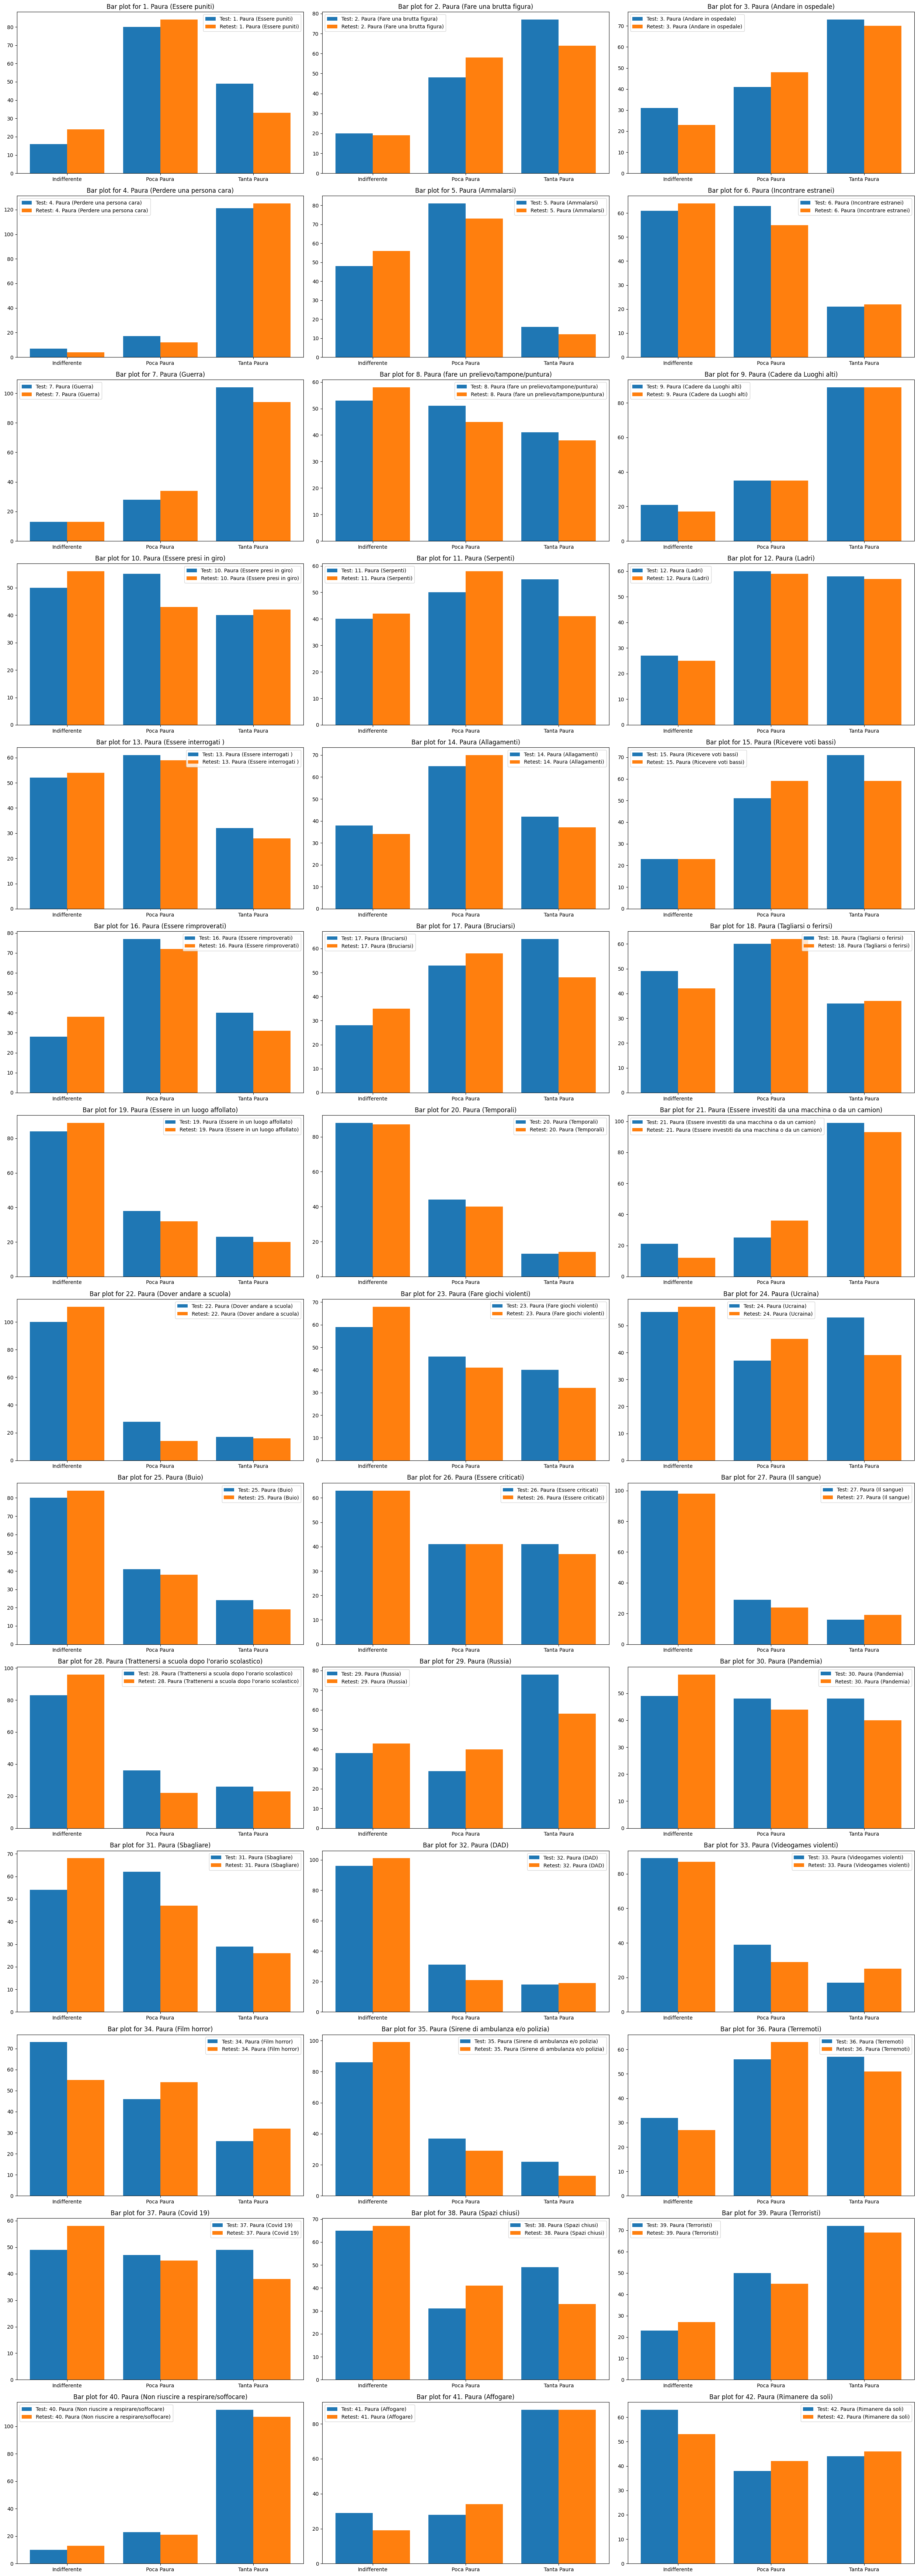

In [15]:
import math

# Calculate the number of rows and columns for the subplots
num_cols = 3
num_rows = math.ceil(len(test_fear_df_experimental.columns) / num_cols)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(25, num_rows * 5))  # Create a new figure with subplots

for i, col in enumerate(test_fear_df_experimental.columns):
    ax = axs[i // num_cols, i % num_cols]  # Get the current axes
    values, counts = np.unique(test_fear_df_experimental[col], return_counts=True)
    ax.bar(values - 0.2, counts, width=0.4, label=f'Test: {col}', align='center')
    values, counts = np.unique(retest_fear_df_experimental[col], return_counts=True)
    ax.bar(values + 0.2, counts, width=0.4, label=f'Retest: {col}', align='center')
    ax.set_title(f'Bar plot for {col}')
    ax.legend()  # Add a legend
    ax.set_xticks([0, 1, 2])  # Set the x-ticks to the possible values
    ax.set_xticklabels(['Indifferente', 'Poca Paura', 'Tanta Paura'])  # Set the x-tick labels


plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the figure

# Fear

In [16]:
test_fear_df_experimental = test_fear_df_experimental.sample(n=len(retest_fear_df_experimental.index))

## Frequency Analysis - Experimental

In [17]:
fa_fear_experimental = frequency_analysis(test_fear_df_experimental, retest_fear_df_experimental)
fa_fear_experimental.to_csv('./report-output/fa_fear_experimental.csv', index=False, sep=';')
fa_fear_experimental

Variable          Frequency Test  \
0                            1. Paura (Essere puniti)   {1: 77, 2: 48, 0: 16}   
1                    10. Paura (Essere presi in giro)   {1: 53, 0: 50, 2: 38}   
2                                11. Paura (Serpenti)   {2: 54, 1: 49, 0: 38}   
3                                   12. Paura (Ladri)   {1: 59, 2: 56, 0: 26}   
4                     13. Paura (Essere interrogati )   {1: 59, 0: 50, 2: 32}   
5                             14. Paura (Allagamenti)   {1: 64, 2: 39, 0: 38}   
6                     15. Paura (Ricevere voti bassi)   {2: 69, 1: 50, 0: 22}   
7                     16. Paura (Essere rimproverati)   {1: 77, 2: 37, 0: 27}   
8                               17. Paura (Bruciarsi)   {2: 60, 1: 53, 0: 28}   
9                     18. Paura (Tagliarsi o ferirsi)   {1: 59, 0: 48, 2: 34}   
10           19. Paura (Essere in un luogo affollato)   {0: 83, 1: 35, 2: 23}   
11                  2. Paura (Fare una brutta figura)   {2: 74, 1: 47, 0: 20}   
12                              20. Paura (Temporali)   {0: 87, 1: 42, 2: 12}   
13  21. Paura (Essere investiti da una macchina o ...   {2: 96, 1: 24, 0: 21}   
14                  22. Paura (Dover andare a scuola)   {0: 96, 1: 28, 2: 17}   
15                   23. Paura (Fare giochi violenti)   {0: 59, 1: 45, 2: 37}   
16                                24. Paura (Ucraina)   {0: 54, 2: 51, 1: 36}   
17                                   25. Paura (Buio)   {0: 78, 1: 40, 2: 23}   
18                       26. Paura (Essere criticati)   {0: 62, 2: 40, 1: 39}   
19                              27. Paura (Il sangue)   {0: 98, 1: 28, 2: 15}   
20  28. Paura (Trattenersi a scuola dopo l'orario ...   {0: 81, 1: 35, 2: 25}   
21                                 29. Paura (Russia)   {2: 76, 0: 37, 1: 28}   
22                      3. Paura (Andare in ospedale)   {2: 70, 1: 40, 0: 31}   
23                               30. Paura (Pandemia)   {0: 48, 2: 47, 1: 46}   
24                              31. Paura (Sbagliare)   {1: 59, 0: 54, 2: 28}   
25                                    32. Paura (DAD)   {0: 93, 1: 30, 2: 18}   
26                    33. Paura (Videogames violenti)   {0: 88, 1: 38, 2: 15}   
27                            34. Paura (Film horror)   {0: 71, 1: 45, 2: 25}   
28        35. Paura (Sirene di ambulanza e/o polizia)   {0: 84, 1: 35, 2: 22}   
29                              36. Paura (Terremoti)   {1: 55, 2: 54, 0: 32}   
30                               37. Paura (Covid 19)   {0: 48, 2: 47, 1: 46}   
31                           38. Paura (Spazi chiusi)   {0: 64, 2: 48, 1: 29}   
32                             39. Paura (Terroristi)   {2: 68, 1: 50, 0: 23}   
33                4. Paura (Perdere una persona cara)   {2: 117, 1: 17, 0: 7}   
34     40. Paura (Non riuscire a respirare/soffocare)  {2: 108, 1: 23, 0: 10}   
35                               41. Paura (Affogare)   {2: 84, 0: 29, 1: 28}   
36                       42. Paura (Rimanere da soli)   {0: 61, 2: 43, 1: 37}   
37                               5. Paura (Ammalarsi)   {1: 79, 0: 48, 2: 14}   
38                     6. Paura (Incontrare estranei)   {1: 62, 0: 59, 2: 20}   
39                                  7. Paura (Guerra)  {2: 101, 1: 27, 0: 13}   
40        8. Paura (fare un prelievo/tampone/puntura)   {0: 51, 1: 49, 2: 41}   
41                   9. Paura (Cadere da Luoghi alti)   {2: 86, 1: 35, 0: 20}   

          Frequency Retest              Difference  
0    {1: 84, 2: 33, 0: 24}    {0: 8, 1: 7, 2: -15}  
1    {0: 56, 1: 43, 2: 42}    {0: 6, 1: -10, 2: 4}  
2    {1: 58, 0: 42, 2: 41}    {0: 4, 1: 9, 2: -13}  
3    {1: 59, 2: 57, 0: 25}     {0: -1, 1: 0, 2: 1}  
4    {1: 59, 0: 54, 2: 28}     {0: 4, 1: 0, 2: -4}  
5    {1: 70, 2: 37, 0: 34}    {0: -4, 1: 6, 2: -2}  
6    {1: 59, 2: 59, 0: 23}    {0: 1, 1: 9, 2: -10}  
7    {1: 72, 0: 38, 2: 31}   {0: 11, 1: -5, 2: -6}  
8    {1: 58, 2: 48, 0: 35}    {0: 7, 1: 5, 2: -12}  
9    {1: 62, 0: 42, 2: 37}     

## Frequency Anlysis - Control

In [18]:
fa_fear_control = frequency_analysis(test_fear_df_control, retest_fear_df_control)
fa_fear_control.to_csv('./report-output/fa_fear_control.csv', index=False, sep=';')
fa_fear_control

Variable          Frequency Test  \
0                            1. Paura (Essere puniti)  {1: 131, 2: 41, 0: 33}   
1                    10. Paura (Essere presi in giro)   {1: 90, 2: 59, 0: 56}   
2                                11. Paura (Serpenti)   {0: 85, 2: 64, 1: 56}   
3                                   12. Paura (Ladri)   {2: 93, 1: 77, 0: 35}   
4                     13. Paura (Essere interrogati )   {0: 77, 1: 76, 2: 52}   
5                             14. Paura (Allagamenti)   {1: 86, 2: 63, 0: 56}   
6                     15. Paura (Ricevere voti bassi)   {2: 93, 1: 85, 0: 27}   
7                     16. Paura (Essere rimproverati)  {1: 119, 2: 43, 0: 43}   
8                               17. Paura (Bruciarsi)   {2: 84, 1: 75, 0: 46}   
9                     18. Paura (Tagliarsi o ferirsi)   {1: 90, 0: 74, 2: 41}   
10           19. Paura (Essere in un luogo affollato)  {0: 140, 1: 44, 2: 21}   
11                  2. Paura (Fare una brutta figura)  {2: 105, 1: 74, 0: 26}   
12                              20. Paura (Temporali)  {0: 149, 1: 43, 2: 13}   
13  21. Paura (Essere investiti da una macchina o ...  {2: 150, 1: 41, 0: 14}   
14                  22. Paura (Dover andare a scuola)  {0: 160, 1: 31, 2: 14}   
15                   23. Paura (Fare giochi violenti)   {1: 79, 0: 69, 2: 57}   
16                                24. Paura (Ucraina)   {2: 83, 0: 71, 1: 51}   
17                                   25. Paura (Buio)  {0: 104, 1: 66, 2: 35}   
18                       26. Paura (Essere criticati)   {0: 83, 1: 66, 2: 56}   
19                              27. Paura (Il sangue)  {0: 127, 1: 48, 2: 30}   
20  28. Paura (Trattenersi a scuola dopo l'orario ...  {0: 114, 1: 61, 2: 30}   
21                                 29. Paura (Russia)  {2: 104, 1: 52, 0: 49}   
22                      3. Paura (Andare in ospedale)  {2: 110, 1: 62, 0: 33}   
23                               30. Paura (Pandemia)   {1: 84, 2: 63, 0: 58}   
24                              31. Paura (Sbagliare)   {1: 80, 0: 77, 2: 48}   
25                                    32. Paura (DAD)  {0: 138, 1: 46, 2: 21}   
26                    33. Paura (Videogames violenti)  {0: 133, 1: 44, 2: 28}   
27                            34. Paura (Film horror)   {0: 94, 1: 57, 2: 54}   
28        35. Paura (Sirene di ambulanza e/o polizia)  {0: 123, 1: 62, 2: 20}   
29                              36. Paura (Terremoti)   {1: 90, 2: 79, 0: 36}   
30                               37. Paura (Covid 19)   {1: 75, 0: 66, 2: 64}   
31                           38. Paura (Spazi chiusi)   {0: 93, 1: 58, 2: 54}   
32                             39. Paura (Terroristi)  {2: 113, 1: 59, 0: 33}   
33                4. Paura (Perdere una persona cara)   {2: 184, 1: 19, 0: 2}   
34     40. Paura (Non riuscire a respirare/soffocare)   {2: 174, 1: 26, 0: 5}   
35                               41. Paura (Affogare)  {2: 147, 1: 35, 0: 23}   
36                       42. Paura (Rimanere da soli)   {0: 79, 1: 72, 2: 54}   
37                               5. Paura (Ammalarsi)  {1: 105, 0: 81, 2: 19}   
38                     6. Paura (Incontrare estranei)   {0: 98, 1: 76, 2: 31}   
39                                  7. Paura (Guerra)  {2: 151, 1: 42, 0: 12}   
40        8. Paura (fare un prelievo/tampone/puntura)   {1: 84, 0: 72, 2: 49}   
41                   9. Paura (Cadere da Luoghi alti)  {2: 138, 1: 41, 0: 26}   

          Frequency Retest               Difference  
0   {1: 120, 0: 45, 2: 40}   {0: 12, 1: -11, 2: -1}  
1    {0: 87, 1: 70, 2: 48}  {0: 31, 1: -20, 2: -11}  
2    {0: 92, 2: 60, 1: 53}     {0: 7, 1: -3, 2: -4}  
3    {1: 90, 2: 65, 0: 50}   {0: 15, 1: 13, 2: -28}  
4   {0: 104, 1: 55, 2: 46}   {0: 27, 1: -21, 2: -6}  
5    {1: 77, 0: 72, 2: 56}    {0: 16, 1: -9, 2: -7}  
6    {2: 88, 1: 77, 0: 40}    {0: 13, 1: -8, 2: -5}  
7    {1: 93, 0: 75, 2: 37}   {0: 32, 1: -26, 2: -6}  
8    {1: 90, 0: 65, 2: 50}   {0: 19, 1: 15, 2: -34}  
9    {0: 96, 1: 72, 2

## Alexander Govern - H0: Stessa Media, H1: Media Diversa

In [19]:
alex_fear = test_alexandergovern(test_fear_df_experimental, retest_fear_df_experimental).sort_values(by='Alexander Govern p-value')
alex_fear.to_csv('./report-output/alexander_govern_fear.csv', index=False, sep=';')
alex_fear

Variable  Alexander Govern Stat  \
0                            1. Paura (Essere puniti)               4.587074   
28        35. Paura (Sirene di ambulanza e/o polizia)               4.090374   
27                            34. Paura (Film horror)               3.168577   
21                                 29. Paura (Russia)               2.812311   
8                               17. Paura (Bruciarsi)               2.188788   
7                     16. Paura (Essere rimproverati)               2.158667   
14                  22. Paura (Dover andare a scuola)               1.916097   
30                               37. Paura (Covid 19)               1.891797   
33                4. Paura (Perdere una persona cara)               1.883156   
20  28. Paura (Trattenersi a scuola dopo l'orario ...               1.727906   
2                                11. Paura (Serpenti)               1.646196   
24                              31. Paura (Sbagliare)               1.591458   
31                           38. Paura (Spazi chiusi)               1.582488   
23                               30. Paura (Pandemia)               1.330267   
35                               41. Paura (Affogare)               1.174314   
16                                24. Paura (Ucraina)               1.118419   
15                   23. Paura (Fare giochi violenti)               1.055481   
37                               5. Paura (Ammalarsi)               0.913983   
6                     15. Paura (Ricevere voti bassi)               0.806933   
26                    33. Paura (Videogames violenti)               0.797233   
17                                   25. Paura (Buio)               0.647666   
36                       42. Paura (Rimanere da soli)               0.596870   
11                  2. Paura (Fare una brutta figura)               0.563956   
40        8. Paura (fare un prelievo/tampone/puntura)               0.535862   
10           19. Paura (Essere in un luogo affollato)               0.514219   
9                     18. Paura (Tagliarsi o ferirsi)               0.502198   
39                                  7. Paura (Guerra)               0.405232   
4                     13. Paura (Essere interrogati )               0.403255   
22                      3. Paura (Andare in ospedale)               0.377666   
25                                    32. Paura (DAD)               0.337821   
13  21. Paura (Essere investiti da una macchina o ...               0.262588   
41                   9. Paura (Cadere da Luoghi alti)               0.246649   
34     40. Paura (Non riuscire a respirare/soffocare)               0.147600   
19                              27. Paura (Il sangue)               0.115624   
18                       26. Paura (Essere criticati)               0.081681   
38                     6. Paura (Incontrare estranei)               0.062831   
32                             39. Paura (Terroristi)               0.055602   
12                              20. Paura (Temporali)               0.032354   
5                             14. Paura (Allagamenti)               0.026751   
3                                   12. Paura (Ladri)               0.026320   
29                              36. Paura (Terremoti)               0.025289   
1                    10. Paura (Essere presi in giro)               0.021555   

    Alexander Govern p-value  
0                   0.032214  
28                  0.043128  
27                  0.075068  
21                  0.093544  
8                   0.139019  
7                   0.141768  
14                  0.166288  
30                  0.168999  
33                  0.169976  
20                  0.188679  
2                   0.199478  
24                  0.207118  
31                  0.208403  
23                  0.248758  
35                  0.278517  
16                  0.290259  
15                  0.304248  
37                  0.339060  
6              

## Mannwhitneyu - H0: Stessa distribuzione, H1: Distribuzione Diversa

In [20]:
mann_fear = mannwhitneyu_test(test_fear_df_experimental, retest_fear_df_experimental).sort_values(by='p-value')
mann_fear.to_csv('./report-output/mannwhitneyu_fear.csv', index=False, sep=';')
mann_fear

Variable  Statistic   p-value
0                            1. Paura (Essere puniti)    11250.0  0.015604
28        35. Paura (Sirene di ambulanza e/o polizia)    11089.5  0.023505
14                  22. Paura (Dover andare a scuola)    10893.0  0.036286
21                                 29. Paura (Russia)    11071.5  0.037161
20  28. Paura (Trattenersi a scuola dopo l'orario ...    10870.5  0.057226
8                               17. Paura (Bruciarsi)    10902.0  0.066394
7                     16. Paura (Essere rimproverati)    10854.5  0.071094
24                              31. Paura (Sbagliare)    10818.5  0.083367
30                               37. Paura (Covid 19)    10829.0  0.084128
2                                11. Paura (Serpenti)    10784.0  0.095236
23                               30. Paura (Pandemia)    10689.0  0.122982
31                           38. Paura (Spazi chiusi)    10657.5  0.129692
15                   23. Paura (Fare giochi violenti)    10613.5  0.145577
16                                24. Paura (Ucraina)    10597.5  0.153766
6                     15. Paura (Ricevere voti bassi)    10571.5  0.158201
37                               5. Paura (Ammalarsi)    10541.5  0.162277
11                  2. Paura (Fare una brutta figura)    10512.0  0.179801
25                                    32. Paura (DAD)    10408.5  0.201451
39                                  7. Paura (Guerra)    10388.5  0.210298
17                                   25. Paura (Buio)    10420.5  0.214796
40        8. Paura (fare un prelievo/tampone/puntura)    10425.5  0.225758
10           19. Paura (Essere in un luogo affollato)    10381.5  0.229708
4                     13. Paura (Essere interrogati )    10340.5  0.265458
38                     6. Paura (Incontrare estranei)    10161.0  0.363140
18                       26. Paura (Essere criticati)    10109.5  0.395941
34     40. Paura (Non riuscire a respirare/soffocare)    10055.5  0.411003
1                    10. Paura (Essere presi in giro)    10067.5  0.422140
32                             39. Paura (Terroristi)    10027.5  0.445236
13  21. Paura (Essere investiti da una macchina o ...     9918.0  0.516154
29                              36. Paura (Terremoti)     9886.5  0.534080
12                              20. Paura (Temporali)     9886.5  0.536866
19                              27. Paura (Il sangue)     9854.5  0.561961
3                                   12. Paura (Ladri)     9840.5  0.563005
5                             14. Paura (Allagamenti)     9839.5  0.563626
41                   9. Paura (Cadere da Luoghi alti)     9676.5  0.672921
22                      3. Paura (Andare in ospedale)     9656.5  0.674823
26                    33. Paura (Videogames violenti)     9612.5  0.710864
9                     18. Paura (Tagliarsi o ferirsi)     9480.0  0.764468
36                       42. Paura (Rimanere da soli)     9428.5  0.787457
35                               41. Paura (Affogare)     9431.5  0.803698
33                4. Paura (Perdere una persona cara)     9368.5  0.916261
27                            34. Paura (Film horror)     8767.5  0.967757

## Data Understanding

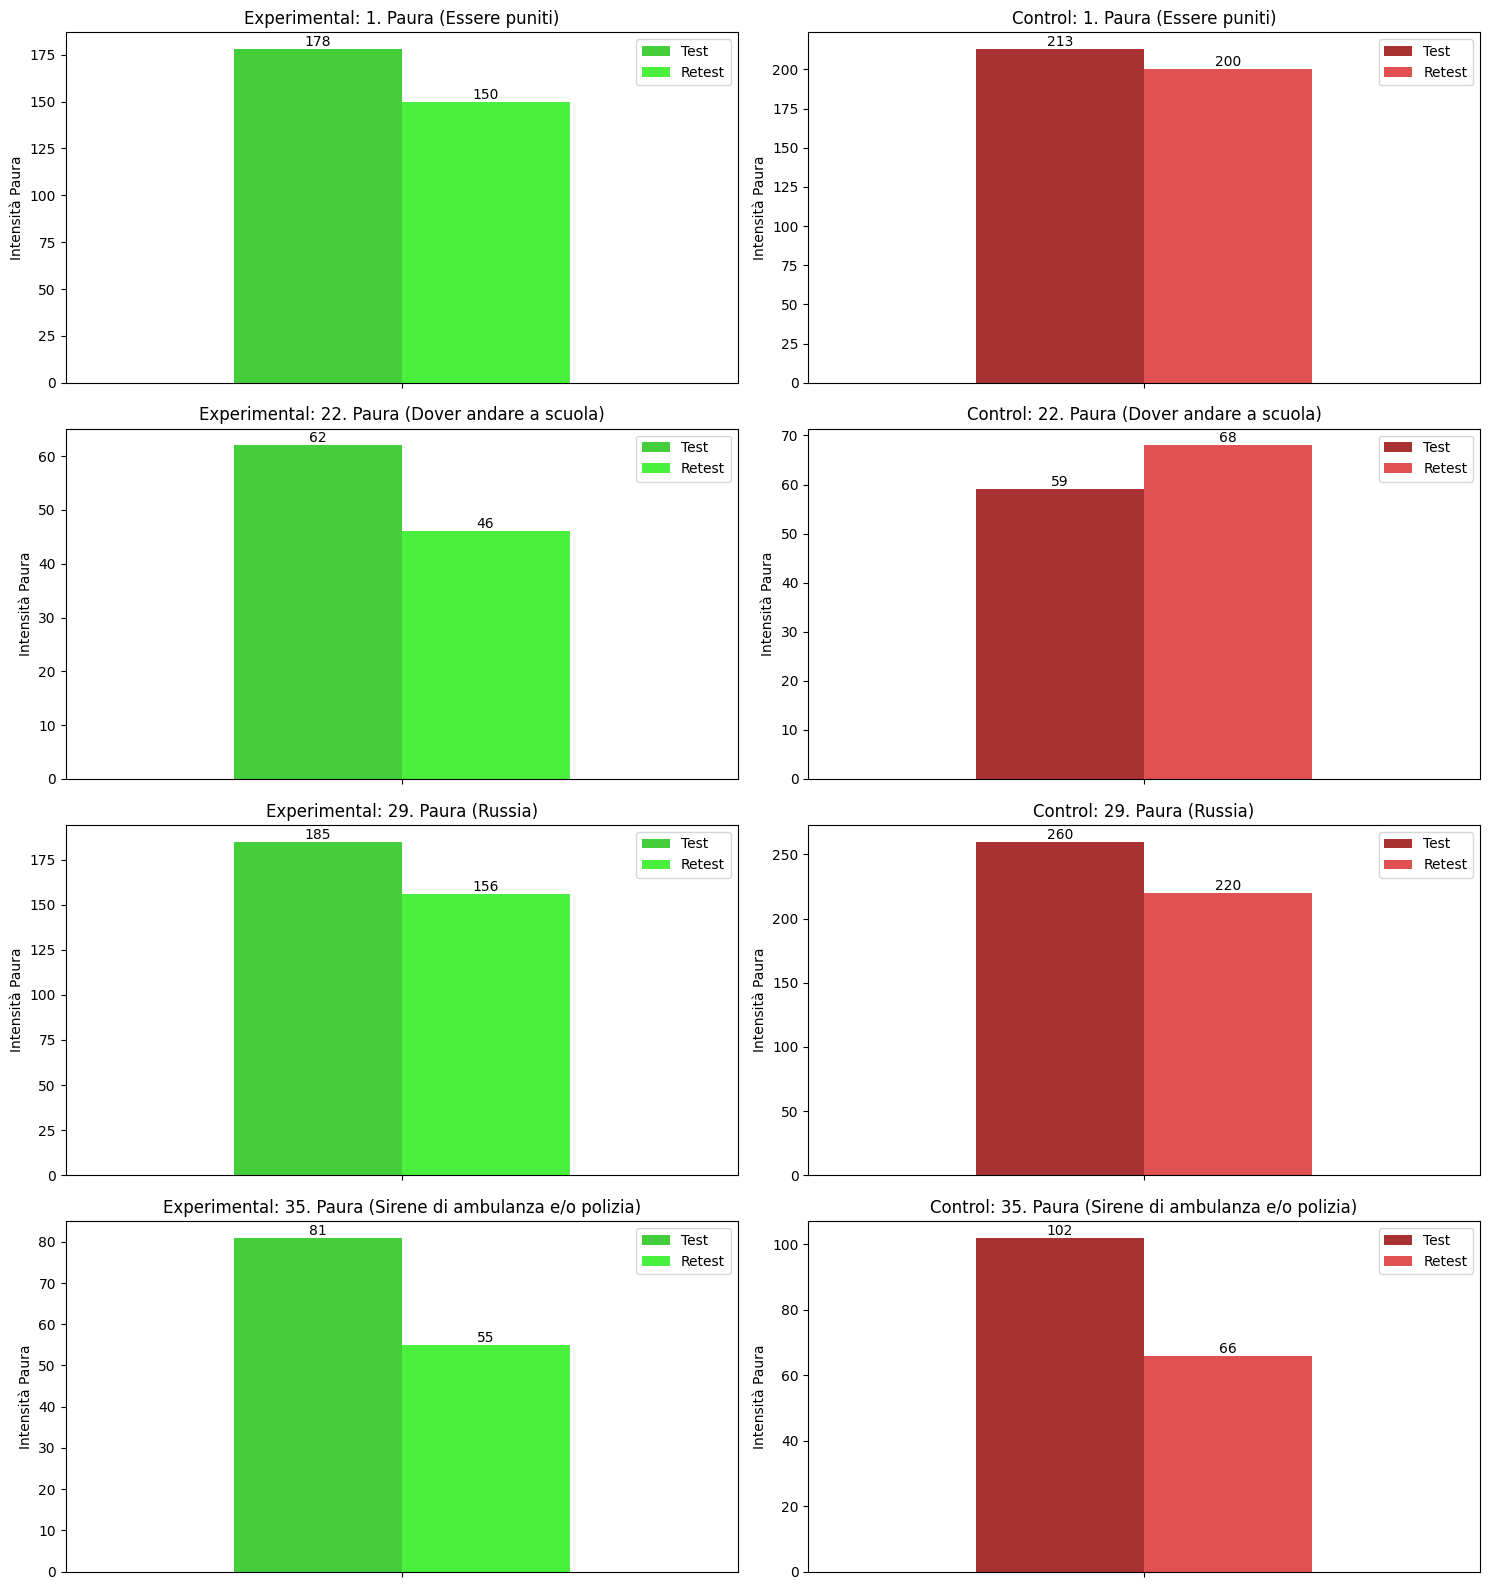

In [21]:
significant_var = np.unique(np.append(alex_fear[alex_fear['Alexander Govern p-value'] < 0.05]['Variable'].to_numpy(), mann_fear[mann_fear['p-value'] < 0.05]['Variable'].to_numpy()))

fig, axs = plt.subplots(len(significant_var), 2, figsize=(15, 4 * len(significant_var)))

colors_experimental = ['#44cf3a', '#4af03e']
colors_control = ['#a83232', '#e05151']

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test': test_fear_df_experimental_sum[test_fear_df_experimental_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_experimental_sum[retest_fear_df_experimental_sum['item'] == var]['sum']
    })
    bars = df_f_exp.plot(kind='bar', ax=axs[i, 0], color=colors_experimental)
    axs[i, 0].set_title(f'Experimental: {var}')
    axs[i, 0].set_ylabel('Intensità Paura')
    axs[i, 0].set_xticklabels([])  # Remove x-ticks labels

    # Add the data value on top of each bar
    for bar in bars.patches:
        axs[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test': test_fear_df_control_sum[test_fear_df_control_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_control_sum[retest_fear_df_control_sum['item'] == var]['sum']
    })
    bars = df_f_ctrl.plot(kind='bar', ax=axs[i, 1], color=colors_control)
    axs[i, 1].set_title(f'Control: {var}')
    axs[i, 1].set_ylabel('Intensità Paura')
    axs[i, 1].set_xticklabels([])  # Remove x-ticks labels

    # Add the data value on top of each bar
    for bar in bars.patches:
        axs[i, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./report-output/fear_outcome.png')
plt.show()

In [27]:
# Initialize an empty DataFrame
df_all = pd.DataFrame()

for i, var in enumerate(significant_var):
    # Experimental
    df_exp = pd.DataFrame({
        'Test Experimental': test_fear_df_experimental_sum[test_fear_df_experimental_sum['item'] == var]['sum'],
        'Retest Experimental': retest_fear_df_experimental_sum[retest_fear_df_experimental_sum['item'] == var]['sum'],
        'Test Control': test_fear_df_control_sum[test_fear_df_control_sum['item'] == var]['sum'],
        'Retest Control': retest_fear_df_control_sum[retest_fear_df_control_sum['item'] == var]['sum']
    })
    df_exp['Variable'] = var

    # Concatenate the dataframes
    df_all = pd.concat([df_all, df_exp])

# Reset the index
df_all.reset_index(drop=True, inplace=True)
df_all['Percentage Change Experimental'] = 100 - (df_all['Retest Experimental'] / df_all['Test Experimental']) * 100
df_all['Percentage Change Control'] = 100 - (df_all['Retest Control'] / df_all['Test Control']) * 100
df_all['Difference Test'] = df_all['Test Experimental'] - df_all['Test Control']
df_all['Difference Retest'] = df_all['Retest Experimental'] - df_all['Retest Control']

# Print the DataFrame
# df_all.to_csv('./report-output/fear_outcome.csv', index=False, sep=';')
df_all

Test Experimental  Retest Experimental  Test Control  Retest Control  \
0                178                  150           213             200   
1                 62                   46            59              68   
2                185                  156           260             220   
3                 81                   55           102              66   

                                      Variable  \
0                     1. Paura (Essere puniti)   
1            22. Paura (Dover andare a scuola)   
2                           29. Paura (Russia)   
3  35. Paura (Sirene di ambulanza e/o polizia)   

   Percentage Change Experimental  Percentage Change Control  Difference Test  \
0                       15.730337                   6.103286              -35   
1                       25.806452                 -15.254237                3   
2                       15.675676                  15.384615              -75   
3                       32.098765                  35.294118              -21   

   Difference Retest  
0                -50  
1                -22  
2                -64  
3                -11

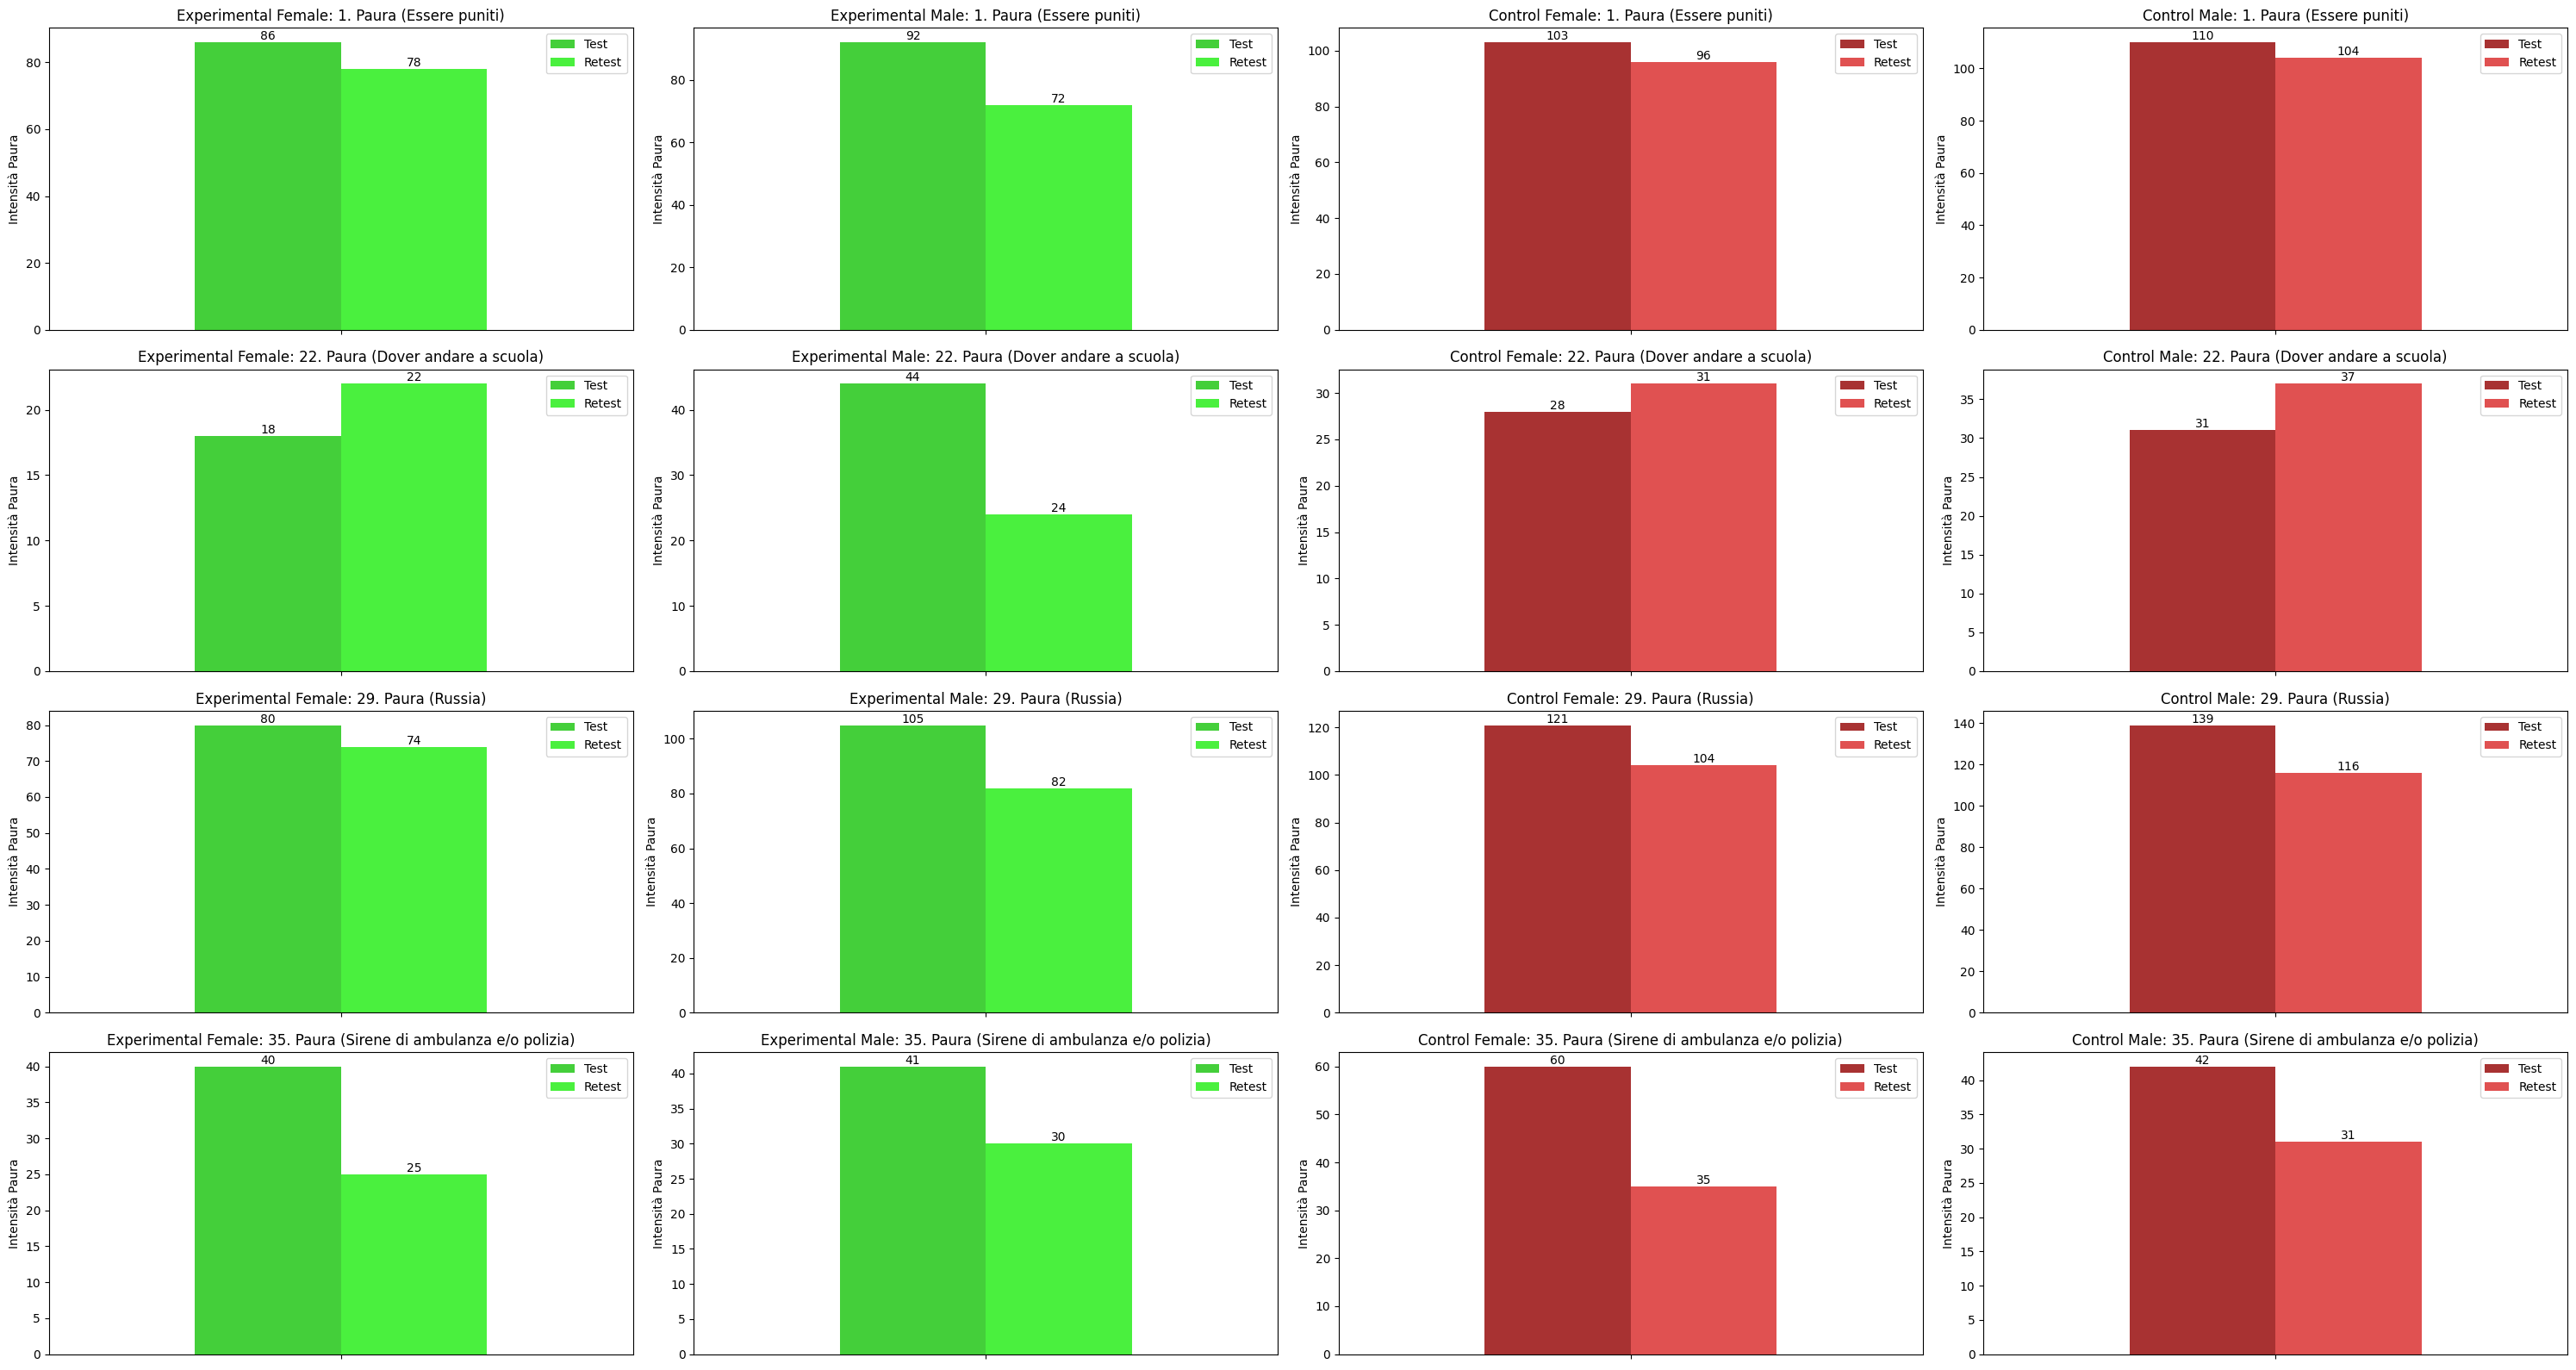

In [23]:
significant_var = np.unique(np.append(alex_fear[alex_fear['Alexander Govern p-value'] < 0.05]['Variable'].to_numpy(), mann_fear[mann_fear['p-value'] < 0.05]['Variable'].to_numpy()))

fig, axs = plt.subplots(len(significant_var), 4, figsize=(30, 4 * len(significant_var)))

colors_experimental = ['#44cf3a', '#4af03e']
colors_control = ['#a83232', '#e05151']

for i, var in enumerate(significant_var):
    # Experimental females
    df_f_exp = pd.DataFrame({
        'Test': test_fear_df_experimental_f_sum[test_fear_df_experimental_f_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_experimental_f_sum[retest_fear_df_experimental_f_sum['item'] == var]['sum']
    })
    bars = df_f_exp.plot(kind='bar', ax=axs[i, 0], color=colors_experimental)
    axs[i, 0].set_title(f'Experimental Female: {var}')
    axs[i, 0].set_ylabel('Intensità Paura')
    axs[i, 0].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Experimental males
    df_m_exp = pd.DataFrame({
        'Test': test_fear_df_experimental_m_sum[test_fear_df_experimental_m_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_experimental_m_sum[retest_fear_df_experimental_m_sum['item'] == var]['sum']
    })
    bars = df_m_exp.plot(kind='bar', ax=axs[i, 1], color=colors_experimental)
    axs[i, 1].set_title(f'Experimental Male: {var}')
    axs[i, 1].set_ylabel('Intensità Paura')
    axs[i, 1].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control females
    df_f_ctrl = pd.DataFrame({
        'Test': test_fear_df_control_f_sum[test_fear_df_control_f_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_control_f_sum[retest_fear_df_control_f_sum['item'] == var]['sum']
    })
    bars = df_f_ctrl.plot(kind='bar', ax=axs[i, 2], color=colors_control)
    axs[i, 2].set_title(f'Control Female: {var}')
    axs[i, 2].set_ylabel('Intensità Paura')
    axs[i, 2].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 2].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control males
    df_m_ctrl = pd.DataFrame({
        'Test': test_fear_df_control_m_sum[test_fear_df_control_m_sum['item'] == var]['sum'],
        'Retest': retest_fear_df_control_m_sum[retest_fear_df_control_m_sum['item'] == var]['sum']
    })
    bars = df_m_ctrl.plot(kind='bar', ax=axs[i, 3], color=colors_control)
    axs[i, 3].set_title(f'Control Male: {var}')
    axs[i, 3].set_ylabel('Intensità Paura')
    axs[i, 3].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 3].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./report-output/fear_outcome_m_f.png')
plt.show()

In [28]:
# Initialize an empty DataFrame
df_all = pd.DataFrame()

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test Female': test_fear_df_experimental_f_sum[test_fear_df_experimental_f_sum['item'] == var]['sum'],
        'Retest Female': retest_fear_df_experimental_f_sum[retest_fear_df_experimental_f_sum['item'] == var]['sum'],
        'Test Male': test_fear_df_experimental_m_sum[test_fear_df_experimental_m_sum['item'] == var]['sum'],
        'Retest Male': retest_fear_df_experimental_m_sum[retest_fear_df_experimental_m_sum['item'] == var]['sum']
    })
    df_f_exp['Group'] = 'Experimental'
    df_f_exp['Variable'] = var

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test Female': test_fear_df_control_f_sum[test_fear_df_control_f_sum['item'] == var]['sum'],
        'Retest Female': retest_fear_df_control_f_sum[retest_fear_df_control_f_sum['item'] == var]['sum'],
        'Test Male': test_fear_df_control_m_sum[test_fear_df_control_m_sum['item'] == var]['sum'],
        'Retest Male': retest_fear_df_control_m_sum[retest_fear_df_control_m_sum['item'] == var]['sum'],
    })
    df_f_ctrl['Group'] = 'Control'
    df_f_ctrl['Variable'] = var

    # Concatenate the dataframes
    df_all = pd.concat([df_all, df_f_exp, df_f_ctrl])

# Reset the index
df_all.reset_index(drop=True, inplace=True)
df_all['Percentage Change Female'] = 100 - (df_all['Retest Female'] / df_all['Test Female']) * 100
df_all['Percentage Change Male'] = 100 - (df_all['Retest Male'] / df_all['Test Male']) * 100

# Print the DataFrame
df_all.to_csv('./report-output/fear_outcome_m_f.csv', index=False, sep=';')
df_all

Test Female  Retest Female  Test Male  Retest Male         Group  \
0           86             78         92           72  Experimental   
1          103             96        110          104       Control   
2           18             22         44           24  Experimental   
3           28             31         31           37       Control   
4           80             74        105           82  Experimental   
5          121            104        139          116       Control   
6           40             25         41           30  Experimental   
7           60             35         42           31       Control   

                                      Variable  Percentage Change Female  \
0                     1. Paura (Essere puniti)                  9.302326   
1                     1. Paura (Essere puniti)                  6.796117   
2            22. Paura (Dover andare a scuola)                -22.222222   
3            22. Paura (Dover andare a scuola)                -10.714286   
4                           29. Paura (Russia)                  7.500000   
5                           29. Paura (Russia)                 14.049587   
6  35. Paura (Sirene di ambulanza e/o polizia)                 37.500000   
7  35. Paura (Sirene di ambulanza e/o polizia)                 41.666667   

   Percentage Change Male  
0               21.739130  
1                5.454545  
2               45.454545  
3              -19.354839  
4               21.904762  
5               16.546763  
6               26.829268  
7               26.190476

In [29]:
time_vs_fear_prec_analysis = [
    ("Tempo sui Videogames", "11. Paura (Serpenti)"),
    ("Tempo sui Videogames", "23. Paura (Fare giochi violenti)"),
    ("Tempo sui Videogames", "33. Paura (Videogames violenti)"),
    ("Tempo sui Videogames Elettronici", "10. Paura (Essere presi in giro)"),
    ("Tempo sui Videogames Elettronici", "11. Paura (Serpenti)"),
    ("Tempo sui Videogames Elettronici", "23. Paura (Fare giochi violenti)"),
    ("Tempo sui Videogames Elettronici", "33. Paura (Videogames violenti)")
]

civil_vs_fear_prec_analysis = [
    ("Senso Civile (Non fare la raccolta differenziata)", "29. Paura (Russia)"),
    ("Senso Civile (Non lavare le mani)", "14. Paura (Allagamenti)"),
    ("Senso Civile (Attraversare con il semaforo rosso)", "5. Paura (Ammalarsi)"),
    ("Senso Civile (Attraversare la strada fuori dalle strisce pedonali)", "5. Paura (Ammalarsi)"),
    ("Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))", "11. Paura (Serpenti)"),
    ("Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))", "12. Paura (Ladri)"),
    ("Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))", "12. Paura (Ladri)"),
    ("Senso Civile (Attraversare la strada fuori dalle strisce pedonali)", "14. Paura (Allagamenti)"),
    ("Senso Civile (Attraversare la strada fuori dalle strisce pedonali)", "18. Paura (Tagliarsi o ferirsi)"),
    ("Senso Civile (Parcheggiare dove è vietato)", "23. Paura (Fare giochi violenti)"),
    ("Senso Civile (Parcheggiare dove è vietato)", "36. Paura (Terremoti)"),
    ("Senso Civile (Non allacciare le cinture di sicurezza)", "5. Paura (Ammalarsi)"),
    ("Senso Civile (Non allacciare le cinture di sicurezza)", "27. Paura (Il sangue)"),
    ("Senso Civile (Dire le parolacce)", "3. Paura (Andare in ospedale)"),
    ("Senso Civile (Dire le parolacce)", "11. Paura (Serpenti)"),
    ("Senso Civile (Dire le parolacce)", "23. Paura (Fare giochi violenti)"),
    ("Senso Civile (Dire le parolacce)", "27. Paura (Il sangue)"),
    ("Senso Civile (Dire le parolacce)", "39. Paura (Terroristi)"),
    ("Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)", "24. Paura (Ucraina)"),
    ("Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)", "30. Paura (Pandemia)"),
    ("Senso Civile (Non aiutare i compagni/e e le altre persone in difficoltà)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Danneggiare gli oggetti altrui)", "30. Paura (Pandemia)"),
    ("Senso Civile (Calpestare i fiori)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Parcheggiare dove è vietato)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Usare il cellulare a pranzo o cena)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Dire le parolacce)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Imbrogliare nel gioco)", "33. Paura (Videogames violenti)"),
    ("Senso Civile (Imbrattare i muri ed i mezzi pubblici (treni,pullman))", "36. Paura (Terremoti)"),
    ("Senso Civile (Spintonare i propri compagni/e)", "39. Paura (Terroristi)")
]

In [30]:
import re

# Calculate the number of plots
n = len(civil_vs_fear_prec_analysis)
ncols = 4  # Set the number of columns to 4
nrows = n  # Set the number of rows to n

# Create a figure and axes
fig, ax = plt.subplots(nrows, ncols, figsize=(35, nrows*5))

# Set the suptitle
fig.suptitle("Significant Results", y=1.02)

# Flatten the axes array if there is more than one plot
if n > 1:
    ax = ax.flatten()

# Iterate over the tuples in civil_vs_fear_prec_analysis
for index, (col1, col2) in enumerate(civil_vs_fear_prec_analysis):
    # Create contingency tables for experimental data, experimental retest data, control data, and control retest data
    contingency_table_experimental = pd.crosstab(test_fear_df_experimental[col2], test_civil_df_experimental[col1])
    contingency_table_experimental_retest = pd.crosstab(retest_fear_df_experimental[col2], retest_civil_df_experimental[col1])
    contingency_table_control = pd.crosstab(test_fear_df_control[col2], test_civil_df_control[col1])
    contingency_table_control_retest = pd.crosstab(retest_fear_df_control[col2], retest_civil_df_control[col1])

    safe_col1 = re.sub('[^A-Za-z0-9]+', '_', col1)
    safe_col2 = re.sub('[^A-Za-z0-9]+', '_', col2)

    filename = './report-output/civic_vs_fear/{}_vs_{}_experimental_test.csv'.format(safe_col1, safe_col2)
    contingency_table_experimental.to_csv(filename, sep=';')

    filename = './report-output/civic_vs_fear/{}_vs_{}_experimental_retest.csv'.format(safe_col1, safe_col2)
    contingency_table_experimental_retest.to_csv(filename, sep=';')

    filename = './report-output/civic_vs_fear/{}_vs_{}_control_test.csv'.format(safe_col1, safe_col2)
    contingency_table_control.to_csv(filename, sep=';')

    filename = './report-output/civic_vs_fear/{}_vs_{}_control_retest.csv'.format(safe_col1, safe_col2)
    contingency_table_control_retest.to_csv(filename, sep=';')

    # Create stacked bar charts on the current subplot for each data set
    contingency_table_experimental.plot(kind='bar', stacked=True, ax=ax[4*index] if n > 1 else ax)
    ax[4*index if n > 1 else ax].set_title(f"Experimental: {col1} and {col2}")

    contingency_table_experimental_retest.plot(kind='bar', stacked=True, ax=ax[4*index+1] if n > 1 else ax)
    ax[4*index+1 if n > 1 else ax].set_title(f"Experimental Retest: {col1} and {col2}")

    contingency_table_control.plot(kind='bar', stacked=True, ax=ax[4*index+2] if n > 1 else ax)
    ax[4*index+2 if n > 1 else ax].set_title(f"Control: {col1} and {col2}")

    contingency_table_control_retest.plot(kind='bar', stacked=True, ax=ax[4*index+3] if n > 1 else ax)
    ax[4*index+3 if n > 1 else ax].set_title(f"Control Retest: {col1} and {col2}")

    # Add x-ticks for all plots
    for i in [4*index, 4*index+1, 4*index+2, 4*index+3]:
        ax[i if n > 1 else ax].set_xticks(range(len(contingency_table_experimental.index)))
        ax[i if n > 1 else ax].set_xticklabels(['Nessuna', 'Poca paura', 'Tanta paura'], rotation=45)
        ax[i if n > 1 else ax].legend(loc='upper left', bbox_to_anchor=(1.0, 1), labels=['Indifferente', 'Poco grave', 'Gravissimo'])

# Remove the unused subplots
if n > 1:
    for i in range(4*n, nrows*ncols):
        fig.delaxes(ax[i])

plt.tight_layout()
plt.savefig('./report-output/civil_vs_fear_test_retest_experimental_control.png')
plt.show()

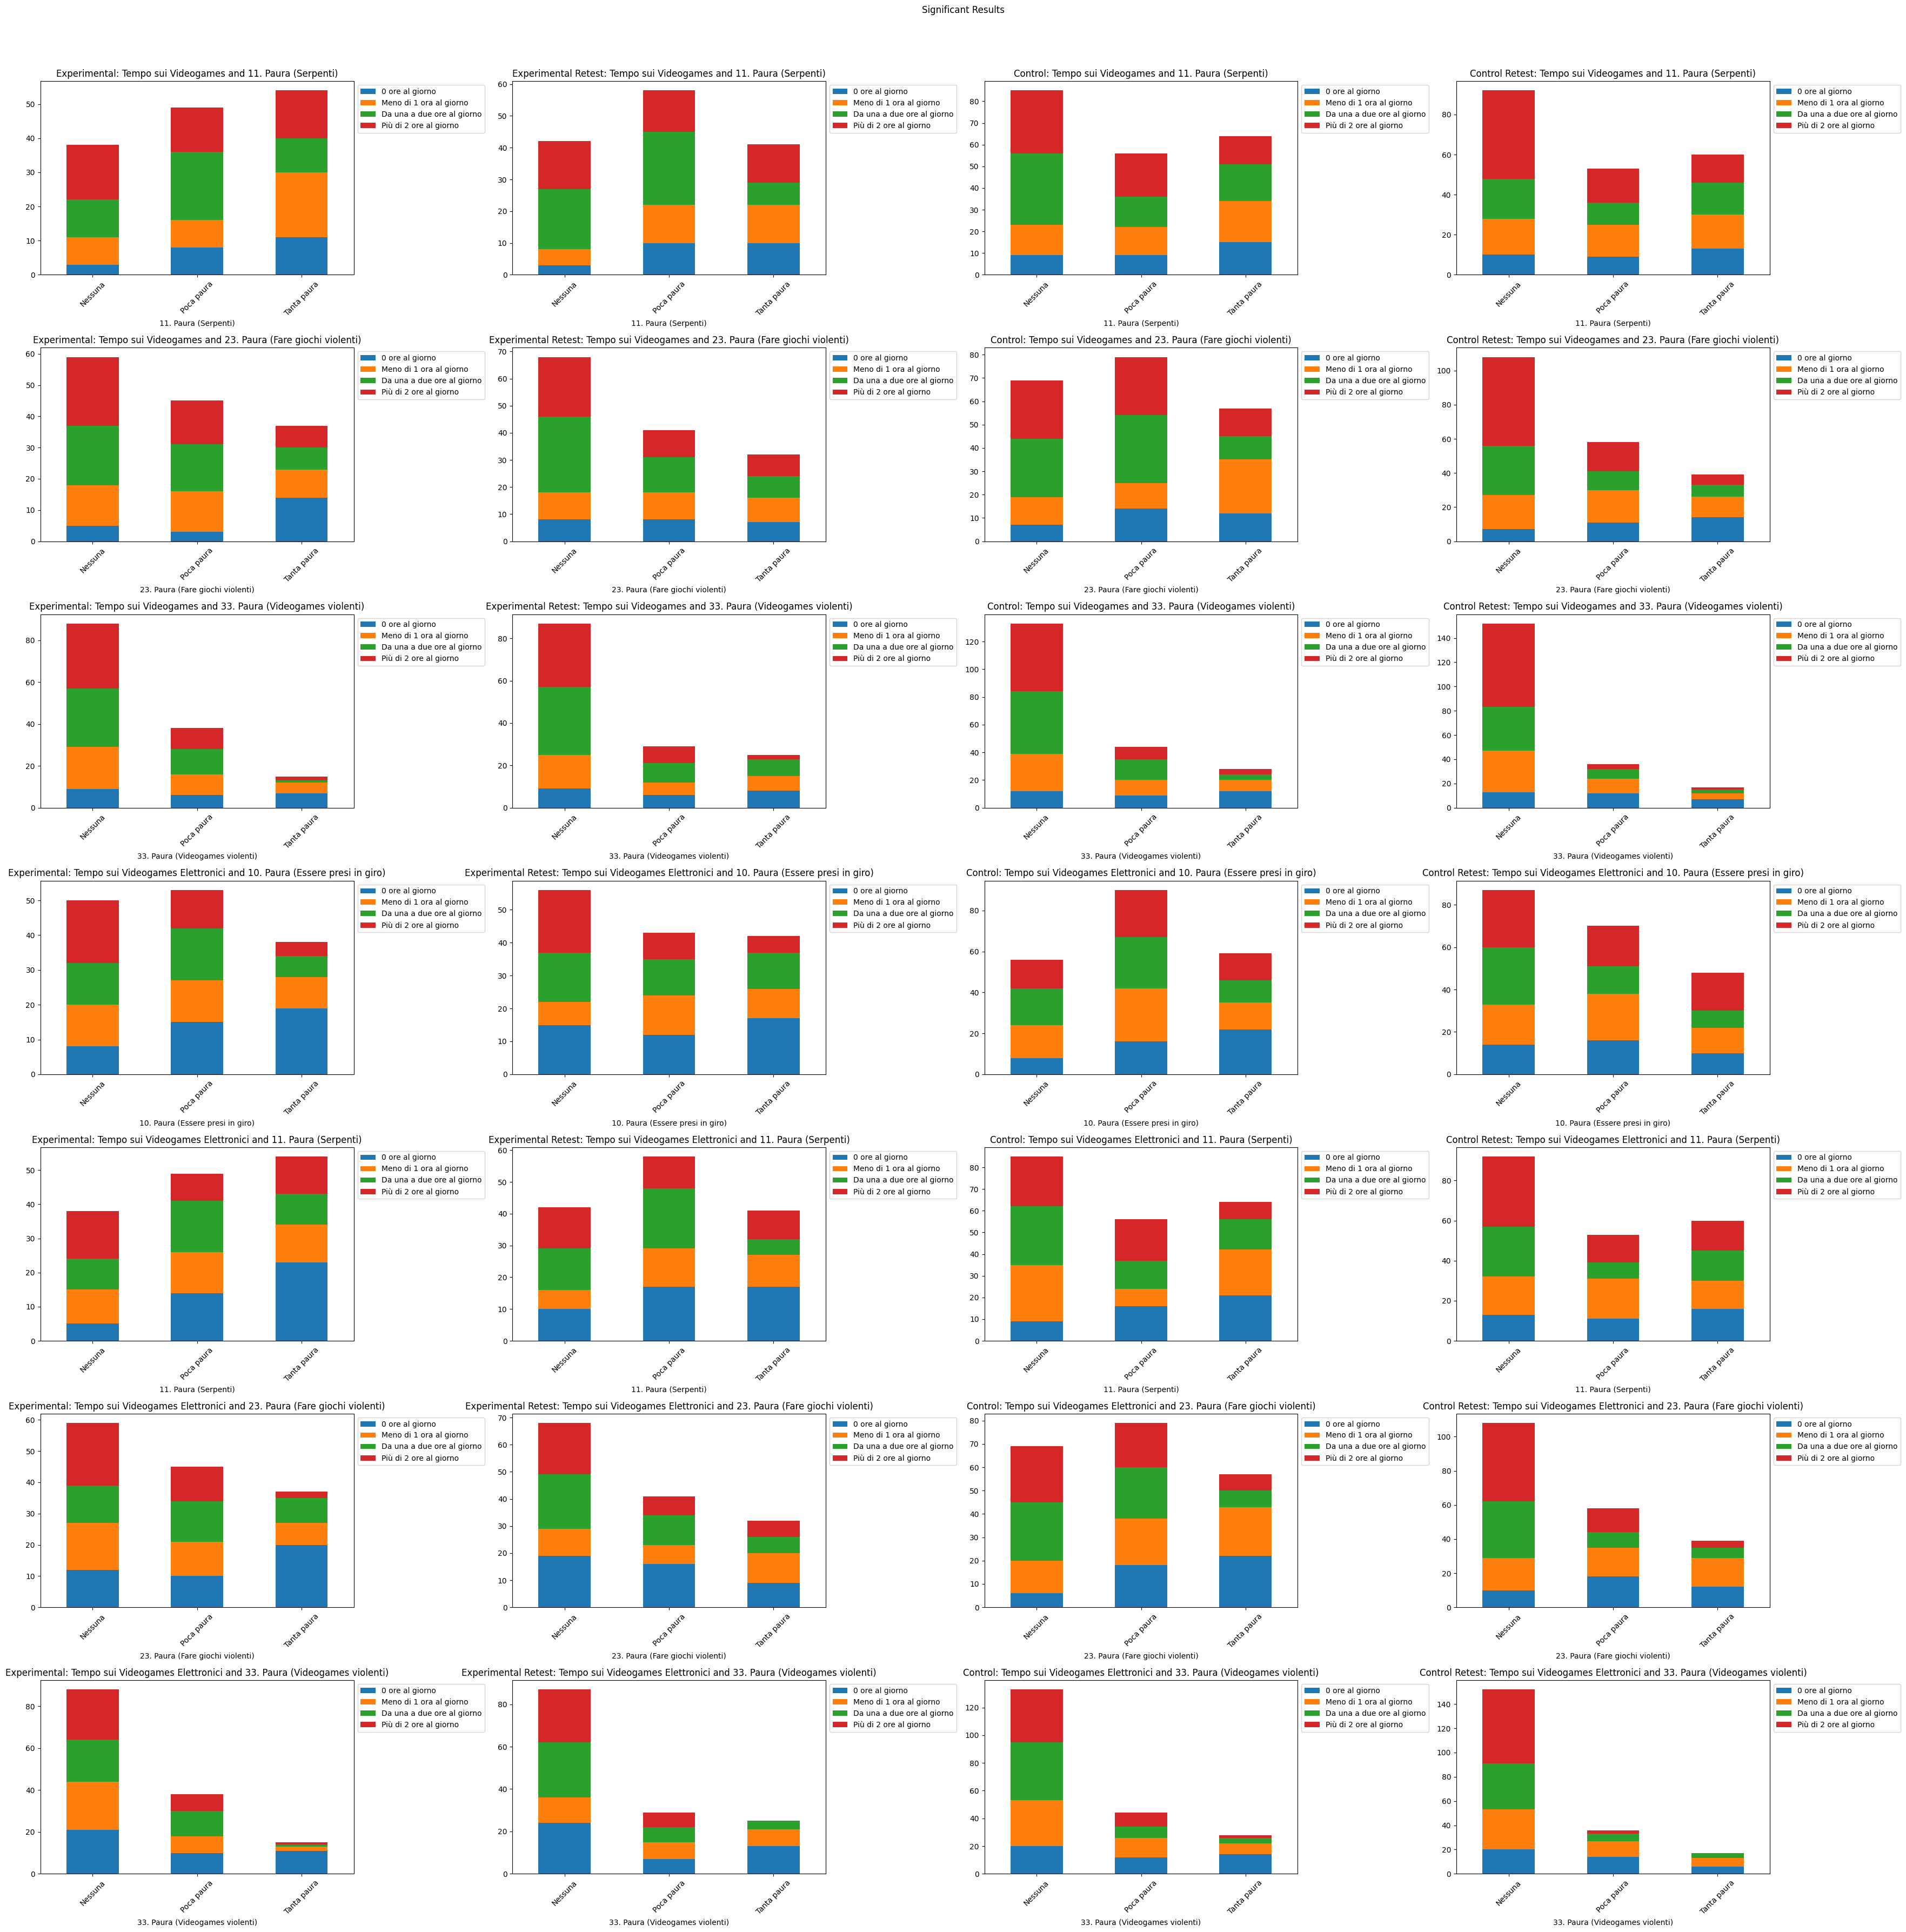

In [31]:
# Calculate the number of plots
n = len(time_vs_fear_prec_analysis)
ncols = 4  # Set the number of columns to 4
nrows = n  # Set the number of rows to n

# Create a figure and axes
fig, ax = plt.subplots(nrows, ncols, figsize=(35, nrows*5))

# Set the suptitle
fig.suptitle("Significant Results", y=1.02)

# Flatten the axes array if there is more than one plot
if n > 1:
    ax = ax.flatten()

# Iterate over the tuples in time_vs_fear_prec_analysis
for index, (col1, col2) in enumerate(time_vs_fear_prec_analysis):
    # Create contingency tables for experimental data, experimental retest data, control data, and control retest data
    contingency_table_experimental = pd.crosstab(test_fear_df_experimental[col2], test_time_df_experimental[col1])
    contingency_table_experimental_retest = pd.crosstab(retest_fear_df_experimental[col2], retest_time_df_experimental[col1])
    contingency_table_control = pd.crosstab(test_fear_df_control[col2], test_time_df_control[col1])
    contingency_table_control_retest = pd.crosstab(retest_fear_df_control[col2], retest_time_df_control[col1])

    safe_col1 = re.sub('[^A-Za-z0-9]+', '_', col1)
    safe_col2 = re.sub('[^A-Za-z0-9]+', '_', col2)

    filename = './report-output/time_vs_fear/{}_vs_{}_experimental_test.csv'.format(safe_col1, safe_col2)
    contingency_table_experimental.to_csv(filename, sep=';')

    filename = './report-output/time_vs_fear/{}_vs_{}_experimental_retest.csv'.format(safe_col1, safe_col2)
    contingency_table_experimental_retest.to_csv(filename, sep=';')

    filename = './report-output/time_vs_fear/{}_vs_{}_control_test.csv'.format(safe_col1, safe_col2)
    contingency_table_control.to_csv(filename, sep=';')

    filename = './report-output/time_vs_fear/{}_vs_{}_control_retest.csv'.format(safe_col1, safe_col2)
    contingency_table_control_retest.to_csv(filename, sep=';')


    # Create stacked bar charts on the current subplot for each data set
    contingency_table_experimental.plot(kind='bar', stacked=True, ax=ax[4*index] if n > 1 else ax)
    ax[4*index if n > 1 else ax].set_title(f"Experimental: {col1} and {col2}")

    contingency_table_experimental_retest.plot(kind='bar', stacked=True, ax=ax[4*index+1] if n > 1 else ax)
    ax[4*index+1 if n > 1 else ax].set_title(f"Experimental Retest: {col1} and {col2}")

    contingency_table_control.plot(kind='bar', stacked=True, ax=ax[4*index+2] if n > 1 else ax)
    ax[4*index+2 if n > 1 else ax].set_title(f"Control: {col1} and {col2}")

    contingency_table_control_retest.plot(kind='bar', stacked=True, ax=ax[4*index+3] if n > 1 else ax)
    ax[4*index+3 if n > 1 else ax].set_title(f"Control Retest: {col1} and {col2}")

    # Add x-ticks for all plots
    for i in [4*index, 4*index+1, 4*index+2, 4*index+3]:
        ax[i if n > 1 else ax].set_xticks(range(len(contingency_table_experimental.index)))
        ax[i if n > 1 else ax].set_xticklabels(['Nessuna', 'Poca paura', 'Tanta paura'], rotation=45)
        ax[i if n > 1 else ax].legend(loc='upper left', bbox_to_anchor=(1.0, 1), labels=['0 ore al giorno', 'Meno di 1 ora al giorno', 'Da una a due ore al giorno', 'Più di 2 ore al giorno'])

# Remove the unused subplots
if n > 1:
    for i in range(4*n, nrows*ncols):
        fig.delaxes(ax[i])

plt.tight_layout()
plt.savefig('./report-output/time_vs_fear_test_retest_experimental_control.png')
plt.show()

# Civil

In [51]:
test_civil_df_experimental = test_civil_df_experimental.sample(n=len(retest_civil_df_experimental.index))

## Frequency Analysis - Experimental

In [52]:
fa_civil_experimental = frequency_analysis(test_civil_df_experimental, retest_civil_df_experimental)
fa_civil_experimental.to_csv('./report-output/fa_civil_experimental.csv', index=False, sep=';')
fa_civil_experimental

Variable         Frequency Test  \
0          Senso Civile (Accendere fuochi nei boschi)  {2: 116, 1: 19, 0: 6}   
1   Senso Civile (Attraversare con il semaforo rosso)  {2: 73, 1: 50, 0: 18}   
2   Senso Civile (Attraversare la strada fuori dal...  {2: 52, 0: 45, 1: 44}   
3                   Senso Civile (Calpestare i fiori)  {2: 60, 1: 58, 0: 23}   
4       Senso Civile (Danneggiare gli oggetti altrui)   {2: 91, 1: 41, 0: 9}   
5                    Senso Civile (Dire le parolacce)  {2: 73, 1: 51, 0: 17}   
6          Senso Civile (Gettare le carte per strada)  {2: 102, 1: 32, 0: 7}   
7   Senso Civile (Gettare mozziconi di sigarette a...  {2: 117, 1: 16, 0: 8}   
8   Senso Civile (Imbrattare i muri ed i mezzi pub...  {2: 90, 1: 41, 0: 10}   
9                Senso Civile (Imbrogliare nel gioco)  {1: 61, 0: 42, 2: 38}   
10      Senso Civile (Lasciare i rifiuti dove capita)  {2: 114, 1: 19, 0: 8}   
11             Senso Civile (Maltrattare gli animali)        {2: 129, 1: 12}   
12  Senso Civile (Non aiutare i compagni/e e le al...  {2: 99, 1: 32, 0: 10}   
13  Senso Civile (Non allacciare le cinture di sic...  {2: 74, 1: 50, 0: 17}   
14  Senso Civile (Non fare la raccolta differenziata)  {2: 94, 1: 37, 0: 10}   
15              Senso Civile (Non indossare il casco)  {2: 76, 1: 49, 0: 16}   
16                  Senso Civile (Non lavare le mani)  {1: 68, 2: 41, 0: 32}   
17         Senso Civile (Parcheggiare dove è vietato)  {2: 68, 1: 58, 0: 15}   
18  Senso Civile (Prendere in giro i propri compag...  {2: 104, 1: 30, 0: 7}   
19      Senso Civile (Spintonare i propri compagni/e)  {2: 101, 1: 31, 0: 9}   
20  Senso Civile (Usare il cellulare a pranzo o cena)  {1: 51, 0: 46, 2: 44}   
21         Senso Civile (Usare il cellulare a scuola)  {2: 92, 1: 33, 0: 16}   
22           Senso Civile (Viaggiare senza biglietto)  {2: 77, 1: 50, 0: 14}   

          Frequency Retest              Difference  
0   {2: 112, 1: 19, 0: 10}     {0: 4, 1: 0, 2: -4}  
1    {2: 65, 1: 51, 0: 25}     {0: 7, 1: 1, 2: -8}  
2    {1: 67, 0: 46, 2: 28}   {0: 1, 1: 23, 2: -24}  
3    {1: 58, 2: 49, 0: 34}   {0: 11, 1: 0, 2: -11}  
4    {2: 84, 1: 46, 0: 11}     {0: 2, 1: 5, 2: -7}  
5    {2: 57, 1: 44, 0: 40}  {0: 23, 1: -7, 2: -16}  
6    {2: 78, 1: 48, 0: 15}   {0: 8, 1: 16, 2: -24}  
7    {2: 98, 1: 32, 0: 11}   {0: 3, 1: 16, 2: -19}  
8    {2: 68, 1: 55, 0: 18}   {0: 8, 1: 14, 2: -22}  
9    {0: 60, 1: 50, 2: 31}  {0: 18, 1: -11, 2: -7}  
10  {2: 103, 1: 28, 0: 10}    {0: 2, 1: 9, 2: -11}  
11   {2: 121, 1: 13, 0: 7}     {0: 7, 1: 1, 2: -8}  
12   {2: 91, 1: 38, 0: 12}     {0: 2, 1: 6, 2: -8}  
13   {1: 57, 2: 52, 0: 32}   {0: 15, 1: 7, 2: -22}  
14   {2: 72, 1: 48, 0: 21}  {0: 11, 1: 11, 2: -22}  
15   {2: 72, 1: 45, 0: 24}    {0: 8, 1: -4, 2: -4}  
16   {1: 66, 0: 40, 2: 35}    {0: 8, 1: -2, 2: -6}  
17   {2: 60, 1: 57, 0: 24}    {0: 9, 1: -1, 2: -8}  
18  {2: 102, 1: 25, 0: 14}    {0: 7, 1: -5, 2: -2}  
19   {2: 91, 1: 38, 0: 12}    {0: 3, 1: 7, 2: -10}  
20   {0: 58, 1: 55, 2: 28}   {0: 12, 1: 4, 2: -16}  
21   {2: 69, 1: 44, 0: 28}  {0: 12, 1: 11, 2: -23}  
22   {2: 78, 1: 42, 0: 21}     {0: 7, 1: -8, 2: 1}

## Frequency Analysis - Control

In [53]:
fa_civil_control = frequency_analysis(test_civil_df_control, retest_civil_df_control)
fa_civil_control.to_csv('./report-output/fa_civil_control.csv', index=False, sep=';')
fa_civil_control

Variable          Frequency Test  \
0          Senso Civile (Accendere fuochi nei boschi)  {2: 180, 1: 14, 0: 11}   
1   Senso Civile (Attraversare con il semaforo rosso)  {2: 103, 1: 72, 0: 30}   
2   Senso Civile (Attraversare la strada fuori dal...   {1: 87, 0: 61, 2: 57}   
3                   Senso Civile (Calpestare i fiori)   {1: 88, 2: 87, 0: 30}   
4       Senso Civile (Danneggiare gli oggetti altrui)  {2: 130, 1: 65, 0: 10}   
5                    Senso Civile (Dire le parolacce)  {2: 105, 1: 70, 0: 30}   
6          Senso Civile (Gettare le carte per strada)   {2: 142, 1: 56, 0: 7}   
7   Senso Civile (Gettare mozziconi di sigarette a...   {2: 151, 1: 46, 0: 8}   
8   Senso Civile (Imbrattare i muri ed i mezzi pub...  {2: 109, 1: 75, 0: 21}   
9                Senso Civile (Imbrogliare nel gioco)   {1: 97, 0: 74, 2: 34}   
10      Senso Civile (Lasciare i rifiuti dove capita)   {2: 160, 1: 41, 0: 4}   
11             Senso Civile (Maltrattare gli animali)    {2: 196, 1: 6, 0: 3}   
12  Senso Civile (Non aiutare i compagni/e e le al...   {2: 146, 1: 54, 0: 5}   
13  Senso Civile (Non allacciare le cinture di sic...  {2: 101, 1: 71, 0: 33}   
14  Senso Civile (Non fare la raccolta differenziata)  {2: 130, 1: 64, 0: 11}   
15              Senso Civile (Non indossare il casco)  {2: 127, 1: 59, 0: 19}   
16                  Senso Civile (Non lavare le mani)   {1: 97, 2: 58, 0: 50}   
17         Senso Civile (Parcheggiare dove è vietato)   {1: 94, 2: 93, 0: 18}   
18  Senso Civile (Prendere in giro i propri compag...   {2: 170, 1: 31, 0: 4}   
19      Senso Civile (Spintonare i propri compagni/e)   {2: 130, 1: 66, 0: 9}   
20  Senso Civile (Usare il cellulare a pranzo o cena)   {1: 96, 0: 65, 2: 44}   
21         Senso Civile (Usare il cellulare a scuola)  {2: 128, 1: 52, 0: 25}   
22           Senso Civile (Viaggiare senza biglietto)  {2: 103, 1: 82, 0: 20}   

          Frequency Retest              Difference  
0   {2: 166, 1: 24, 0: 15}   {0: 4, 1: 10, 2: -14}  
1    {1: 91, 2: 80, 0: 34}   {0: 4, 1: 19, 2: -23}  
2    {1: 94, 0: 74, 2: 37}   {0: 13, 1: 7, 2: -20}  
3    {1: 98, 2: 60, 0: 47}  {0: 17, 1: 10, 2: -27}  
4   {2: 114, 1: 80, 0: 11}   {0: 1, 1: 15, 2: -16}  
5    {2: 74, 1: 74, 0: 57}   {0: 27, 1: 4, 2: -31}  
6   {2: 129, 1: 63, 0: 13}    {0: 6, 1: 7, 2: -13}  
7   {2: 150, 1: 40, 0: 15}    {0: 7, 1: -6, 2: -1}  
8    {2: 92, 1: 84, 0: 29}    {0: 8, 1: 9, 2: -17}  
9    {0: 94, 1: 80, 2: 31}  {0: 20, 1: -17, 2: -3}  
10  {2: 156, 1: 39, 0: 10}    {0: 6, 1: -2, 2: -4}  
11   {2: 180, 1: 21, 0: 4}   {0: 1, 1: 15, 2: -16}  
12  {2: 128, 1: 64, 0: 13}   {0: 8, 1: 10, 2: -18}  
13   {1: 88, 2: 69, 0: 48}  {0: 15, 1: 17, 2: -32}  
14  {2: 108, 1: 81, 0: 16}   {0: 5, 1: 17, 2: -22}  
15   {2: 96, 1: 78, 0: 31}  {0: 12, 1: 19, 2: -31}  
16  {1: 102, 0: 61, 2: 42}   {0: 11, 1: 5, 2: -16}  
17  {1: 112, 2: 61, 0: 32}  {0: 14, 1: 18, 2: -32}  
18  {2: 148, 1: 41, 0: 16}  {0: 12, 1: 10, 2: -22}  
19  {2: 117, 1: 69, 0: 19}   {0: 10, 1: 3, 2: -13}  
20   {1: 84, 0: 84, 2: 37}  {0: 19, 1: -12, 2: -7}  
21   {2: 87, 1: 73, 0: 45}  {0: 20, 1: 21, 2: -41}  
22   {1: 86, 2: 85, 0: 34}   {0: 14, 1: 4, 2: -18}

## Alexander Govern - H0: Stessa Media, H1: Media Diversa

In [55]:
alex_civil = test_alexandergovern(test_civil_df_experimental, retest_civil_df_experimental).sort_values(by='Alexander Govern p-value')
alex_civil.to_csv('./report-output/alexander_govern_civil.csv', index=False, sep=';')
alex_civil

Variable  Alexander Govern Stat  \
5                    Senso Civile (Dire le parolacce)               9.094673   
6          Senso Civile (Gettare le carte per strada)               9.069451   
13  Senso Civile (Non allacciare le cinture di sic...               8.937169   
14  Senso Civile (Non fare la raccolta differenziata)               8.257438   
21         Senso Civile (Usare il cellulare a scuola)               7.854485   
8   Senso Civile (Imbrattare i muri ed i mezzi pub...               7.152827   
7   Senso Civile (Gettare mozziconi di sigarette a...               4.940141   
11             Senso Civile (Maltrattare gli animali)               4.704621   
20  Senso Civile (Usare il cellulare a pranzo o cena)               4.536601   
9                Senso Civile (Imbrogliare nel gioco)               3.724400   
2   Senso Civile (Attraversare la strada fuori dal...               3.648463   
3                   Senso Civile (Calpestare i fiori)               3.078390   
17         Senso Civile (Parcheggiare dove è vietato)               2.065924   
10      Senso Civile (Lasciare i rifiuti dove capita)               1.773593   
19      Senso Civile (Spintonare i propri compagni/e)               1.533829   
1   Senso Civile (Attraversare con il semaforo rosso)               1.498050   
16                  Senso Civile (Non lavare le mani)               1.313836   
15              Senso Civile (Non indossare il casco)               0.973250   
12  Senso Civile (Non aiutare i compagni/e e le al...               0.885437   
18  Senso Civile (Prendere in giro i propri compag...               0.759648   
0          Senso Civile (Accendere fuochi nei boschi)               0.749230   
4       Senso Civile (Danneggiare gli oggetti altrui)               0.730784   
22           Senso Civile (Viaggiare senza biglietto)               0.256474   

    Alexander Govern p-value  
5                   0.002564  
6                   0.002599  
13                  0.002794  
14                  0.004059  
21                  0.005069  
8                   0.007485  
7                   0.026240  
11                  0.030082  
20                  0.033177  
9                   0.053623  
2                   0.056121  
3                   0.079339  
17                  0.150624  
10                  0.182938  
19                  0.215539  
1                   0.220972  
16                  0.251701  
15                  0.323871  
12                  0.346717  
18                  0.383439  
0                   0.386720  
4                   0.392629  
22                  0.612553

## Mannwhitneyu - H0: Stessa distribuzione, H1: Distribuzione Diversa

In [56]:
mann_civil = mannwhitneyu_test(test_civil_df_experimental, retest_civil_df_experimental, alternative='two-sided').sort_values(by='p-value')
mann_civil.to_csv('./report-output/mannwhitneyu_civil.csv', index=False, sep=';')
mann_civil

Variable  Statistic   p-value
6          Senso Civile (Gettare le carte per strada)    11704.5  0.002348
13  Senso Civile (Non allacciare le cinture di sic...    11807.0  0.003135
21         Senso Civile (Usare il cellulare a scuola)    11672.0  0.004446
14  Senso Civile (Non fare la raccolta differenziata)    11640.0  0.004617
5                    Senso Civile (Dire le parolacce)    11714.5  0.005107
8   Senso Civile (Imbrattare i muri ed i mezzi pub...    11585.5  0.006669
7   Senso Civile (Gettare mozziconi di sigarette a...    11240.0  0.010640
20  Senso Civile (Usare il cellulare a pranzo o cena)    11282.5  0.036766
9                Senso Civile (Imbrogliare nel gioco)    11214.0  0.047128
2   Senso Civile (Attraversare la strada fuori dal...    11137.0  0.062997
3                   Senso Civile (Calpestare i fiori)    11035.0  0.085714
11             Senso Civile (Maltrattare gli animali)    10546.5  0.107909
10      Senso Civile (Lasciare i rifiuti dove capita)    10699.0  0.131764
17         Senso Civile (Parcheggiare dove è vietato)    10773.0  0.183883
19      Senso Civile (Spintonare i propri compagni/e)    10660.5  0.199015
1   Senso Civile (Attraversare con il semaforo rosso)    10670.5  0.243185
16                  Senso Civile (Non lavare le mani)    10667.5  0.251614
12  Senso Civile (Non aiutare i compagni/e e le al...    10506.5  0.316004
4       Senso Civile (Danneggiare gli oggetti altrui)    10452.5  0.382378
15              Senso Civile (Non indossare il casco)    10450.5  0.409976
0          Senso Civile (Accendere fuochi nei boschi)    10260.5  0.495594
18  Senso Civile (Prendere in giro i propri compag...    10204.0  0.620681
22           Senso Civile (Viaggiare senza biglietto)    10101.0  0.793563

## Data Understanding

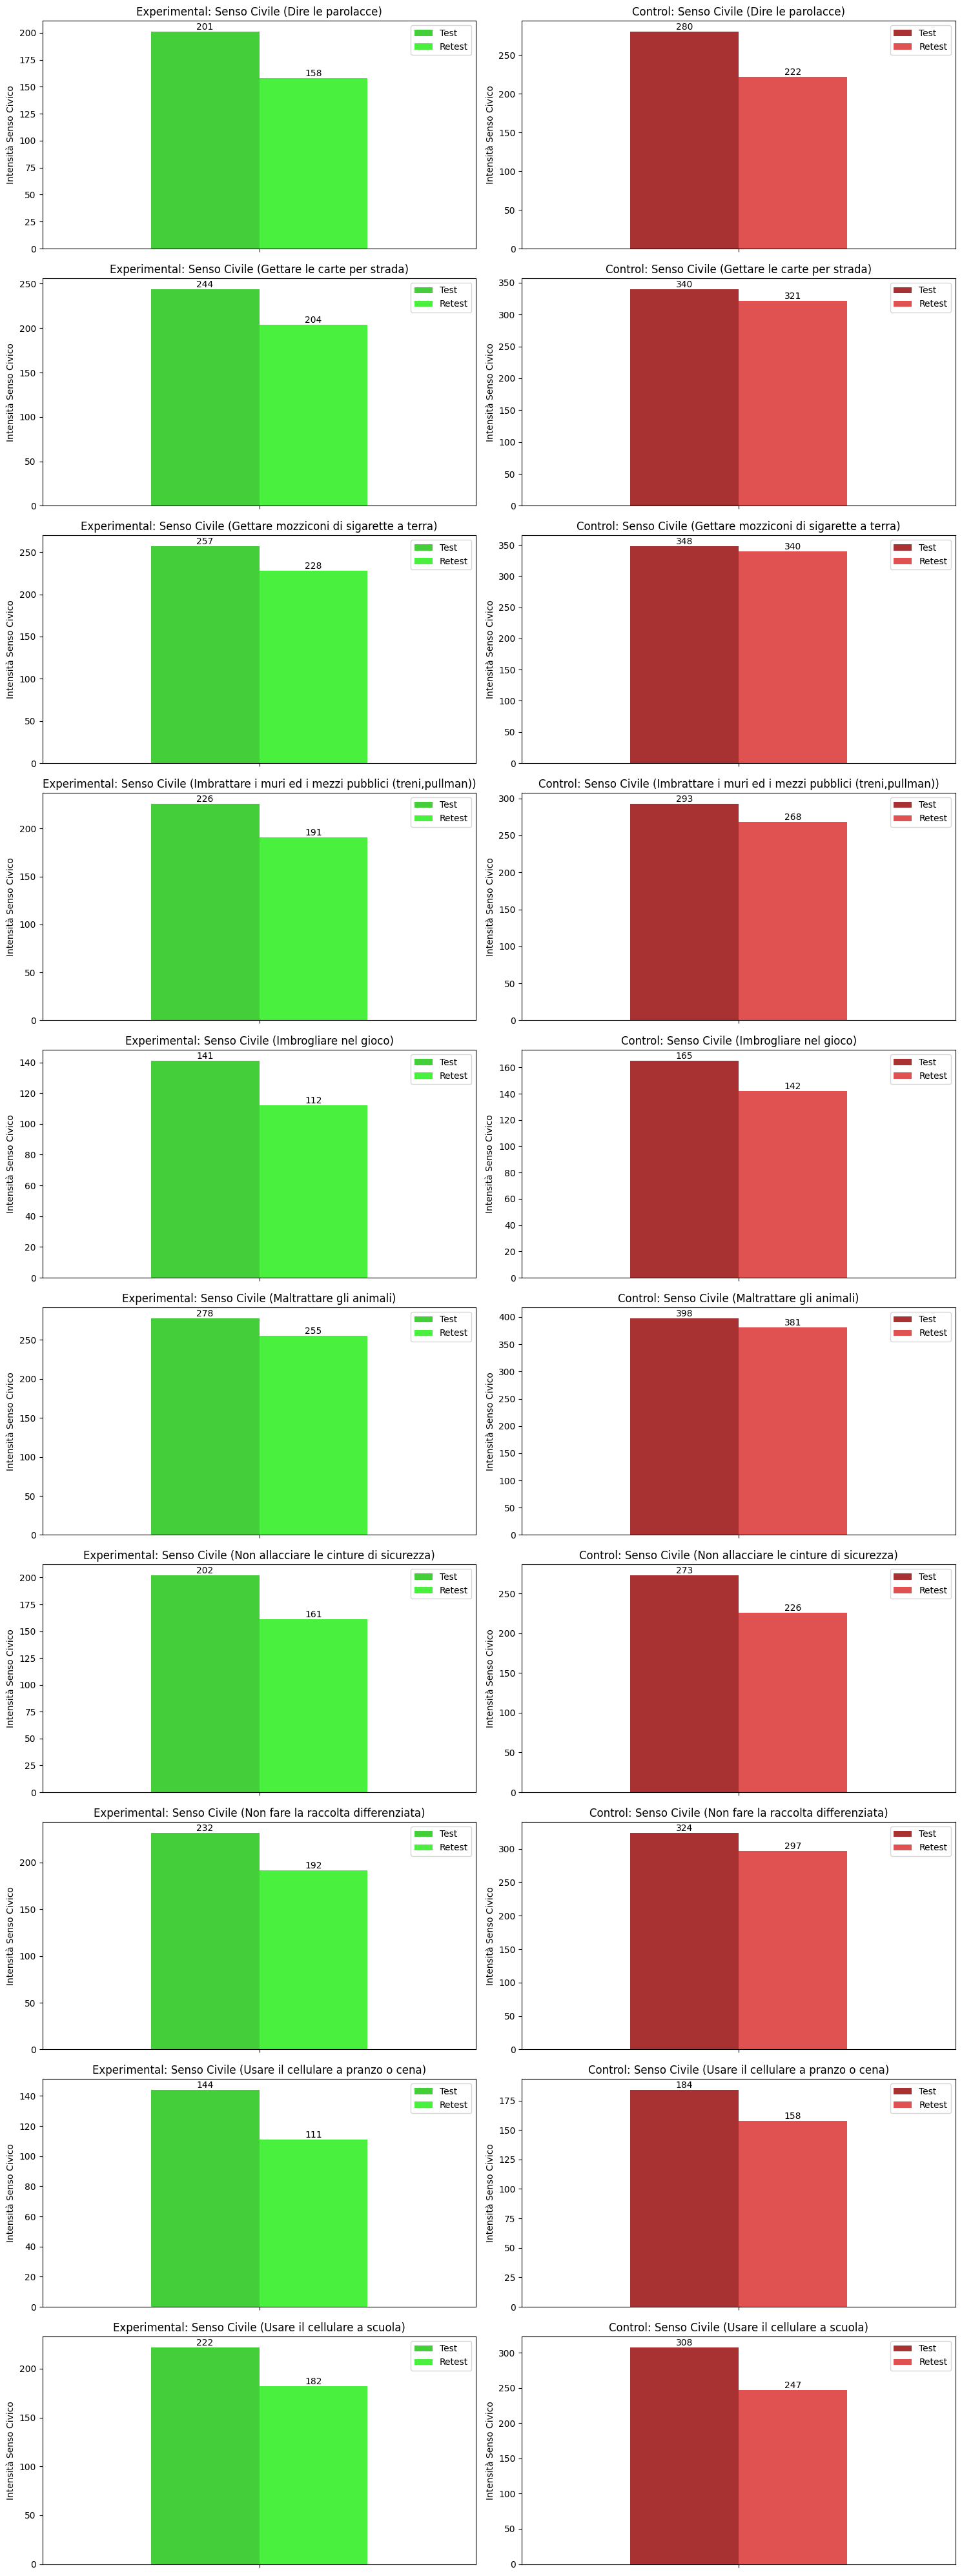

In [57]:
significant_var = np.unique(np.append(alex_civil[alex_civil['Alexander Govern p-value'] < 0.05]['Variable'].to_numpy(), mann_civil[mann_civil['p-value'] < 0.05]['Variable'].to_numpy()))

fig, axs = plt.subplots(len(significant_var), 2, figsize=(15, 4 * len(significant_var)))

colors_experimental = ['#44cf3a', '#4af03e']
colors_control = ['#a83232', '#e05151']

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test': test_civil_df_experimental_sum[test_civil_df_experimental_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_experimental_sum[retest_civil_df_experimental_sum['item'] == var]['sum']
    })
    bars = df_f_exp.plot(kind='bar', ax=axs[i, 0], color=colors_experimental)
    axs[i, 0].set_title(f'Experimental: {var}')
    axs[i, 0].set_ylabel('Intensità Senso Civico')
    axs[i, 0].set_xticklabels([])  # Remove x-ticks labels

    # Add the data value on top of each bar
    for bar in bars.patches:
        axs[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test': test_civil_df_control_sum[test_civil_df_control_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_control_sum[retest_civil_df_control_sum['item'] == var]['sum']
    })
    bars = df_f_ctrl.plot(kind='bar', ax=axs[i, 1], color=colors_control)
    axs[i, 1].set_title(f'Control: {var}')
    axs[i, 1].set_ylabel('Intensità Senso Civico')
    axs[i, 1].set_xticklabels([])  # Remove x-ticks labels

    # Add the data value on top of each bar
    for bar in bars.patches:
        axs[i, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./report-output/civil_outcome.png')
plt.show()

In [66]:
# Initialize an empty DataFrame
df_all = pd.DataFrame()

for i, var in enumerate(significant_var):
    # Experimental
    df_exp = pd.DataFrame({
        'Test Experimental': test_civil_df_experimental_sum[test_civil_df_experimental_sum['item'] == var]['sum'],
        'Retest Experimental': retest_civil_df_experimental_sum[retest_civil_df_experimental_sum['item'] == var]['sum'],
        'Test Control': test_civil_df_control_sum[test_civil_df_control_sum['item'] == var]['sum'],
        'Retest Control': retest_civil_df_control_sum[retest_civil_df_control_sum['item'] == var]['sum']
    })
    df_exp['Variable'] = var

    # Concatenate the dataframes
    df_all = pd.concat([df_all, df_exp])

# Reset the index
df_all.reset_index(drop=True, inplace=True)
df_all['Percentage Change Experimental'] = 100 - (df_all['Retest Experimental'] / df_all['Test Experimental']) * 100
df_all['Percentage Change Control'] = 100 - (df_all['Retest Control'] / df_all['Test Control']) * 100
df_all['Difference Test'] = df_all['Test Experimental'] - df_all['Test Control']
df_all['Difference Retest'] = df_all['Retest Experimental'] - df_all['Retest Control']

# Print the DataFrame
# df_all.to_csv('./report-output/civil_outcome.csv', index=False, sep=';')
df_all

Test Experimental  Retest Experimental  Test Control  Retest Control  \
0                201                  158           280             222   
1                244                  204           340             321   
2                257                  228           348             340   
3                226                  191           293             268   
4                141                  112           165             142   
5                278                  255           398             381   
6                202                  161           273             226   
7                232                  192           324             297   
8                144                  111           184             158   
9                222                  182           308             247   

                                            Variable  \
0                   Senso Civile (Dire le parolacce)   
1         Senso Civile (Gettare le carte per strada)   
2  Senso Civile (Gettare mozziconi di sigarette a...   
3  Senso Civile (Imbrattare i muri ed i mezzi pub...   
4               Senso Civile (Imbrogliare nel gioco)   
5             Senso Civile (Maltrattare gli animali)   
6  Senso Civile (Non allacciare le cinture di sic...   
7  Senso Civile (Non fare la raccolta differenziata)   
8  Senso Civile (Usare il cellulare a pranzo o cena)   
9         Senso Civile (Usare il cellulare a scuola)   

   Percentage Change Experimental  Percentage Change Control  Difference Test  \
0                       21.393035                  20.714286              -79   
1                       16.393443                   5.588235              -96   
2                       11.284047                   2.298851              -91   
3                       15.486726                   8.532423              -67   
4                       20.567376                  13.939394              -24   
5                        8.273381                   4.271357             -120   
6                       20.297030                  17.216117              -71   
7                       17.241379                   8.333333              -92   
8                       22.916667                  14.130435              -40   
9                       18.018018                  19.805195              -86   

   Difference Retest  
0                -64  
1               -117  
2               -112  
3                -77  
4                -30  
5               -126  
6                -65  
7               -105  
8                -47  
9                -65

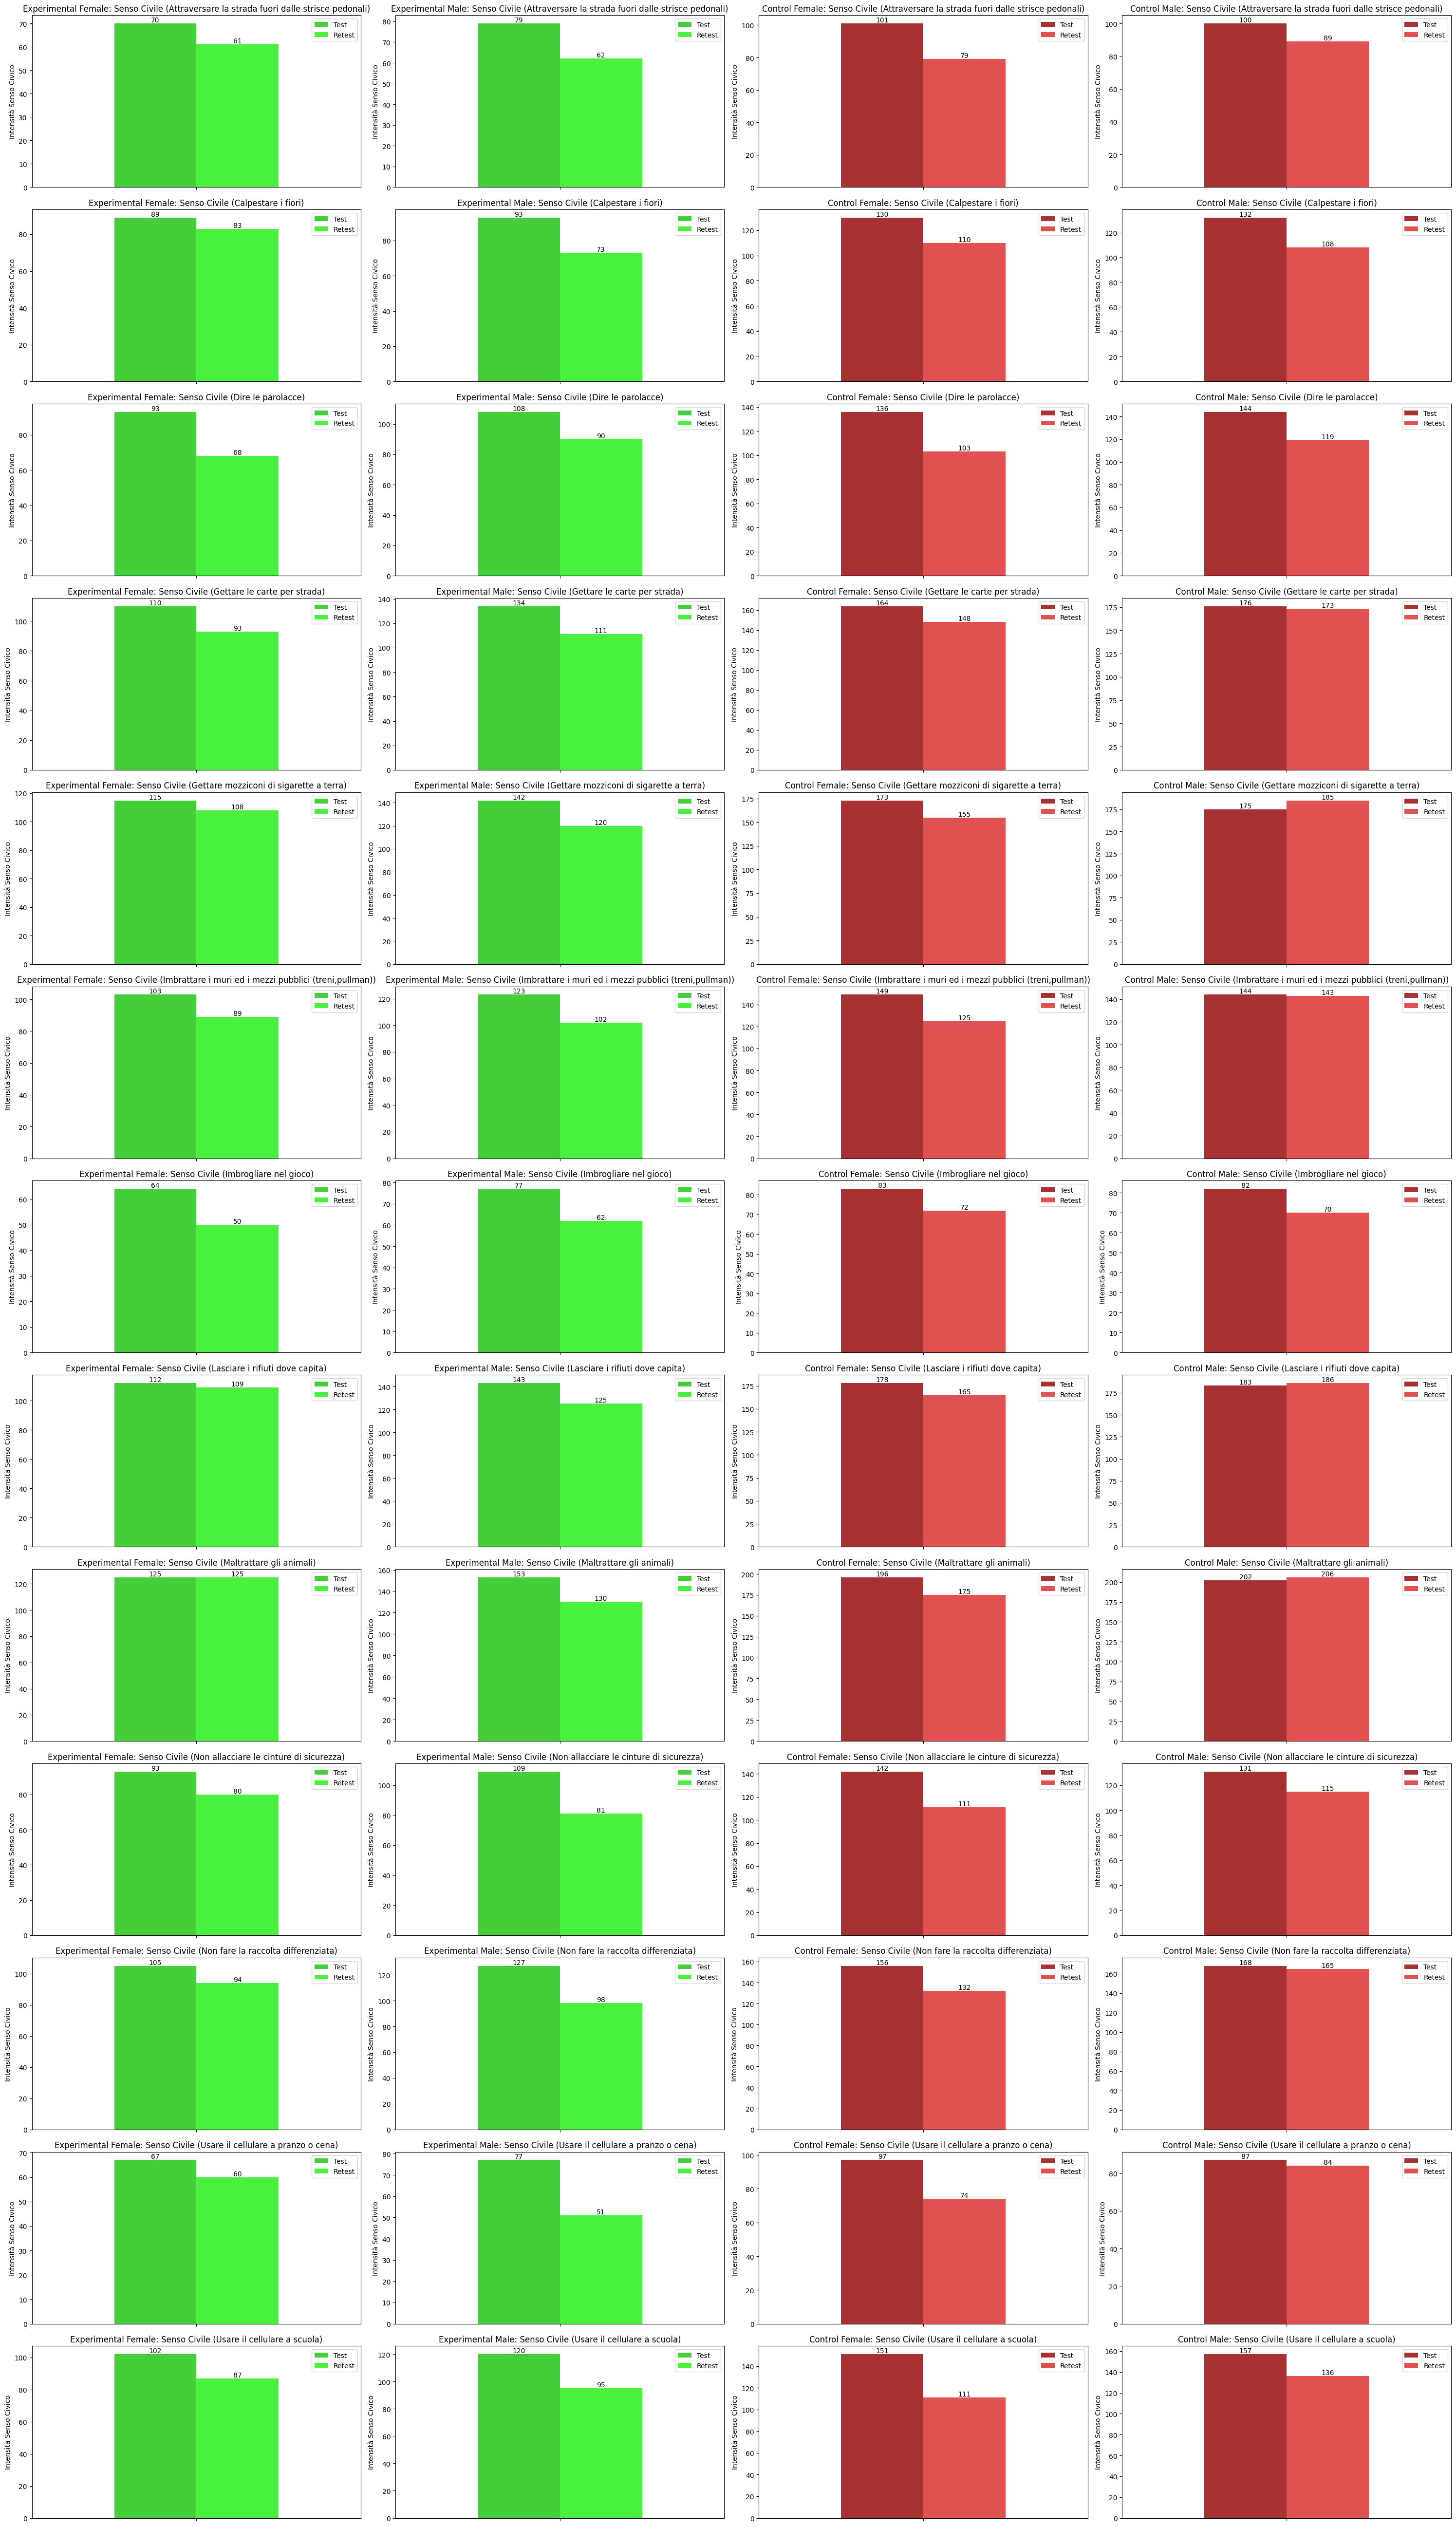

In [ ]:
significant_var = np.unique(np.append(alex_civil[alex_civil['Alexander Govern p-value'] < 0.05]['Variable'].to_numpy(), mann_civil[mann_civil['p-value'] < 0.05]['Variable'].to_numpy()))

fig, axs = plt.subplots(len(significant_var), 4, figsize=(30, 4 * len(significant_var)))

colors_experimental = ['#44cf3a', '#4af03e']
colors_control = ['#a83232', '#e05151']

for i, var in enumerate(significant_var):
    # Experimental females
    df_f_exp = pd.DataFrame({
        'Test': test_civil_df_experimental_f_sum[test_civil_df_experimental_f_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_experimental_f_sum[retest_civil_df_experimental_f_sum['item'] == var]['sum']
    })
    bars = df_f_exp.plot(kind='bar', ax=axs[i, 0], color=colors_experimental)
    axs[i, 0].set_title(f'Experimental Female: {var}')
    axs[i, 0].set_ylabel('Intensità Senso Civico')
    axs[i, 0].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Experimental males
    df_m_exp = pd.DataFrame({
        'Test': test_civil_df_experimental_m_sum[test_civil_df_experimental_m_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_experimental_m_sum[retest_civil_df_experimental_m_sum['item'] == var]['sum']
    })
    bars = df_m_exp.plot(kind='bar', ax=axs[i, 1], color=colors_experimental)
    axs[i, 1].set_title(f'Experimental Male: {var}')
    axs[i, 1].set_ylabel('Intensità Senso Civico')
    axs[i, 1].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control females
    df_f_ctrl = pd.DataFrame({
        'Test': test_civil_df_control_f_sum[test_civil_df_control_f_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_control_f_sum[retest_civil_df_control_f_sum['item'] == var]['sum']
    })
    bars = df_f_ctrl.plot(kind='bar', ax=axs[i, 2], color=colors_control)
    axs[i, 2].set_title(f'Control Female: {var}')
    axs[i, 2].set_ylabel('Intensità Senso Civico')
    axs[i, 2].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 2].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

    # Control males
    df_m_ctrl = pd.DataFrame({
        'Test': test_civil_df_control_m_sum[test_civil_df_control_m_sum['item'] == var]['sum'],
        'Retest': retest_civil_df_control_m_sum[retest_civil_df_control_m_sum['item'] == var]['sum']
    })
    bars = df_m_ctrl.plot(kind='bar', ax=axs[i, 3], color=colors_control)
    axs[i, 3].set_title(f'Control Male: {var}')
    axs[i, 3].set_ylabel('Intensità Senso Civico')
    axs[i, 3].set_xticklabels([])  # Remove x-ticks labels
    for bar in bars.patches:
        axs[i, 3].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 int(bar.get_height()), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('./report-output/civil_outcome_m_f.png')
plt.show()

In [64]:
# Initialize an empty DataFrame
df_all = pd.DataFrame()

for i, var in enumerate(significant_var):
    # Experimental
    df_f_exp = pd.DataFrame({
        'Test Female': test_civil_df_experimental_f_sum[test_civil_df_experimental_f_sum['item'] == var]['sum'],
        'Retest Female': retest_civil_df_experimental_f_sum[retest_civil_df_experimental_f_sum['item'] == var]['sum'],
        'Test Male': test_civil_df_experimental_m_sum[test_civil_df_experimental_m_sum['item'] == var]['sum'],
        'Retest Male': retest_civil_df_experimental_m_sum[retest_civil_df_experimental_m_sum['item'] == var]['sum']
    })
    df_f_exp['Group'] = 'Experimental'
    df_f_exp['Variable'] = var

    # Control
    df_f_ctrl = pd.DataFrame({
        'Test Female': test_civil_df_control_f_sum[test_civil_df_control_f_sum['item'] == var]['sum'],
        'Retest Female': retest_civil_df_control_f_sum[retest_civil_df_control_f_sum['item'] == var]['sum'],
        'Test Male': test_civil_df_control_m_sum[test_civil_df_control_m_sum['item'] == var]['sum'],
        'Retest Male': retest_civil_df_control_m_sum[retest_civil_df_control_m_sum['item'] == var]['sum'],
    })
    df_f_ctrl['Group'] = 'Control'
    df_f_ctrl['Variable'] = var

    # Concatenate the dataframes
    df_all = pd.concat([df_all, df_f_exp, df_f_ctrl])

# Reset the index
df_all.reset_index(drop=True, inplace=True)
df_all['Percentage Change Female'] = 100 - (df_all['Retest Female'] / df_all['Test Female']) * 100
df_all['Percentage Change Male'] = 100 - (df_all['Retest Male'] / df_all['Test Male']) * 100

# Print the DataFrame
df_all.to_csv('./report-output/civil_outcome_m_f.csv', index=False, sep=';')
df_all

Test Female  Retest Female  Test Male  Retest Male         Group  \
0            93             68        108           90  Experimental   
1           136            103        144          119       Control   
2           110             93        134          111  Experimental   
3           164            148        176          173       Control   
4           115            108        142          120  Experimental   
5           173            155        175          185       Control   
6           103             89        123          102  Experimental   
7           149            125        144          143       Control   
8            64             50         77           62  Experimental   
9            83             72         82           70       Control   
10          125            125        153          130  Experimental   
11          196            175        202          206       Control   
12           93             80        109           81  Experimental   
13          142            111        131          115       Control   
14          105             94        127           98  Experimental   
15          156            132        168          165       Control   
16           67             60         77           51  Experimental   
17           97             74         87           84       Control   
18          102             87        120           95  Experimental   
19          151            111        157          136       Control   

                                             Variable  \
0                    Senso Civile (Dire le parolacce)   
1                    Senso Civile (Dire le parolacce)   
2          Senso Civile (Gettare le carte per strada)   
3          Senso Civile (Gettare le carte per strada)   
4   Senso Civile (Gettare mozziconi di sigarette a...   
5   Senso Civile (Gettare mozziconi di sigarette a...   
6   Senso Civile (Imbrattare i muri ed i mezzi pub...   
7   Senso Civile (Imbrattare i muri ed i mezzi pub...   
8                Senso Civile (Imbrogliare nel gioco)   
9                Senso Civile (Imbrogliare nel gioco)   
10             Senso Civile (Maltrattare gli animali)   
11             Senso Civile (Maltrattare gli animali)   
12  Senso Civile (Non allacciare le cinture di sic...   
13  Senso Civile (Non allacciare le cinture di sic...   
14  Senso Civile (Non fare la raccolta differenziata)   
15  Senso Civile (Non fare la raccolta differenziata)   
16  Senso Civile (Usare il cellulare a pranzo o cena)   
17  Senso Civile (Usare il cellulare a pranzo o cena)   
18         Senso Civile (Usare il cellulare a scuola)   
19         Senso Civile (Usare il cellulare a scuola)   

    Percentage Change Female  Percentage Change Male  
0                  26.881720               16.666667  
1                  24.264706               17.361111  
2                  15.454545               17.164179  
3                   9.756098                1.704545  
4                   6.086957               15.492958  
5                  10.404624               -5.714286  
6                  13.592233               17.073171  
7                  16.107383                0.694444  
8                  21.875000               19.480519  
9                  13.253012               14.634146  
10                  0.000000               15.032680  
11                 10.714286               -1.980198  
12                 13.978495               25.688073  
13                 21.830986               12.213740  
14                 10.476190               22.834646  
15                 15.384615                1.785714  
16                 10.447761               33.766234  
17                 23.711340                3.448276  
18                 14.705882               20.833333  
19                 26.490066               13.375796